##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Uncertainty-aware Deep Language Learning with BERT-SNGP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

In the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp), you learned how to build SNGP model on top of a deep residual network to improve its ability to quantify its uncertainty. In this tutorial, you will apply SNGP to a natural language understanding (NLU) task by building it on top of a deep BERT encoder to improve deep NLU model's ability in detecting out-of-scope queries. 

Specifically, you will:
* Build BERT-SNGP, a SNGP-augmented [BERT](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) model.
* Load the [CLINC Out-of-scope (OOS)](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset.
* Train the BERT-SNGP model.
* Evaluate the BERT-SNGP model's performance in uncertainty calibration and out-of-domain detection.

Beyond CLINC OOS, the SNGP model has been applied to large-scale datasets such as [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), and to the image datasets such as [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100) and [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012). 
For benchmark results of SNGP and other uncertainty methods, as well as high-quality implementation with end-to-end training / evaluation scripts, you can check out the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines) benchmark.

## Setup

In [2]:
!pip uninstall -y tensorflow tf-text

Found existing installation: tensorflow 2.8.0


Uninstalling tensorflow-2.8.0:


  Successfully uninstalled tensorflow-2.8.0


In [3]:
!pip install "tensorflow-text==2.8.*"

  Using cached tensorflow_text-2.8.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.9 MB)


  Using cached tensorflow-2.8.0-cp37-cp37m-manylinux2010_x86_64.whl (497.5 MB)


In [4]:
!pip install -U tf-models-official==2.7.0

  Using cached tf_models_official-2.7.0-py2.py3-none-any.whl (1.8 MB)


  Using cached Cython-0.29.28-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)


  Using cached sacrebleu-2.0.0-py3-none-any.whl (90 kB)


  Using cached tensorflow_model_optimization-0.7.2-py2.py3-none-any.whl (237 kB)


  Using cached kaggle-1.5.12-py3-none-any.whl


  Using cached tensorflow_addons-0.16.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)


  Using cached google_api_python_client-2.42.0-py2.py3-none-any.whl (8.3 MB)


  Using cached pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl


  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (47.8 MB)


  Using cached sentencepiece-0.1.96-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)


  Using cached py_cpuinfo-8.0.0-py3-none-any.whl


  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)


  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)


  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)


  Using cached httplib2-0.20.4-py3-none-any.whl (96 kB)


  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)


  Using cached google_api_core-2.7.1-py3-none-any.whl (114 kB)


  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)


  Using cached python_slugify-6.1.1-py2.py3-none-any.whl (9.1 kB)


  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)


  Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)


  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)


  Using cached regex-2022.3.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (749 kB)


  Using cached portalocker-2.4.0-py2.py3-none-any.whl (16 kB)


  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [5]:
import matplotlib.pyplot as plt

import sklearn.metrics
import sklearn.calibration

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as layers
import official.nlp.optimization as optimization

This tutorial needs the GPU to run efficiently. Check if the GPU is available. 

In [6]:
tf.__version__

'2.8.0'

In [7]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
assert gpus, """
  No GPU(s) found! This tutorial will take many hours to run without a GPU.

  You may hit this error if the installed tensorflow package is not
  compatible with the CUDA and CUDNN versions."""

First implement a standard BERT classifier following the [classify text with BERT](https://www.tensorflow.org/tutorials/text/classify_text_with_bert) tutorial. We will use the [BERT-base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) encoder, and the built-in [`ClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py) as the classifier.

In [9]:
#@title Standard BERT model

PREPROCESS_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
MODEL_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

class BertClassifier(tf.keras.Model):
  def __init__(self, 
               num_classes=150, inner_dim=768, dropout_rate=0.1,
               **classifier_kwargs):
    
    super().__init__()
    self.classifier_kwargs = classifier_kwargs

    # Initiate the BERT encoder components.
    self.bert_preprocessor = hub.KerasLayer(PREPROCESS_HANDLE, name='preprocessing')
    self.bert_hidden_layer = hub.KerasLayer(MODEL_HANDLE, trainable=True, name='bert_encoder')

    # Defines the encoder and classification layers.
    self.bert_encoder = self.make_bert_encoder()
    self.classifier = self.make_classification_head(num_classes, inner_dim, dropout_rate)

  def make_bert_encoder(self):
    text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = self.bert_preprocessor(text_inputs)
    encoder_outputs = self.bert_hidden_layer(encoder_inputs)
    return tf.keras.Model(text_inputs, encoder_outputs)

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.ClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        **self.classifier_kwargs)

  def call(self, inputs, **kwargs):
    encoder_outputs = self.bert_encoder(inputs)
    classifier_inputs = encoder_outputs['sequence_output']
    return self.classifier(classifier_inputs, **kwargs)


### Build SNGP model

To implement a BERT-SNGP model, you only need to replace the `ClassificationHead` with the built-in [`GaussianProcessClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py). Spectral normalization is already pre-packaged into this classification head. Like in the [SNGP tutorial](https://www.tensorflow.org/tutorials/uncertainty/sngp), add a covariance reset callback to the model, so the model automatically reset the covariance estimator at the begining of a new epoch to avoid counting the same data twice.

In [10]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the begining of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [11]:
class SNGPBertClassifier(BertClassifier):

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.GaussianProcessClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        gp_cov_momentum=-1,
        temperature=30.,
        **self.classifier_kwargs)

  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs['callbacks'] = list(kwargs.get('callbacks', []))
    kwargs['callbacks'].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

Note: The `GaussianProcessClassificationHead` takes a new argument `temperature`. It corresponds to the $\lambda$ parameter in the __mean-field approximation__ introduced in the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp). In practice, this value is usually treated as a hyperparameter, and is finetuned to optimize the model's calibration performance.

### Load CLINC OOS dataset

Now load the [CLINC OOS](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset. This dataset contains 15000 user's spoken queries collected over 150 intent classes, it also contains 1000 out-of-domain (OOD) sentences that are not covered by any of the known classes.

In [12]:
(clinc_train, clinc_test, clinc_test_oos), ds_info = tfds.load(
    'clinc_oos', split=['train', 'test', 'test_oos'], with_info=True, batch_size=-1)

Make the train and test data.

In [13]:
train_examples = clinc_train['text']
train_labels = clinc_train['intent']

# Makes the in-domain (IND) evaluation data.
ind_eval_data = (clinc_test['text'], clinc_test['intent'])

Create a OOD evaluation dataset. For this, combine the in-domain test data `clinc_test` and the out-of-domain data `clinc_test_oos`. We will also assign label 0 to the in-domain examples, and label 1 to the out-of-domain examples. 

In [14]:
test_data_size = ds_info.splits['test'].num_examples
oos_data_size = ds_info.splits['test_oos'].num_examples

# Combines the in-domain and out-of-domain test examples.
oos_texts = tf.concat([clinc_test['text'], clinc_test_oos['text']], axis=0)
oos_labels = tf.constant([0] * test_data_size + [1] * oos_data_size)

# Converts into a TF dataset.
ood_eval_dataset = tf.data.Dataset.from_tensor_slices(
    {"text": oos_texts, "label": oos_labels})

### Train and evaluate

First set up the basic training configurations.

In [15]:
TRAIN_EPOCHS = 3
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 256

In [16]:
#@title

def bert_optimizer(learning_rate, 
                   batch_size=TRAIN_BATCH_SIZE, epochs=TRAIN_EPOCHS, 
                   warmup_rate=0.1):
  """Creates an AdamWeightDecay optimizer with learning rate schedule."""
  train_data_size = ds_info.splits['train'].num_examples
  
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(warmup_rate * num_train_steps)  

  # Creates learning schedule.
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=num_train_steps,
      end_learning_rate=0.0)  
  
  return optimization.AdamWeightDecay(
      learning_rate=lr_schedule,
      weight_decay_rate=0.01,
      epsilon=1e-6,
      exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

In [17]:
optimizer = bert_optimizer(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [18]:
fit_configs = dict(batch_size=TRAIN_BATCH_SIZE,
                   epochs=TRAIN_EPOCHS,
                   validation_batch_size=EVAL_BATCH_SIZE, 
                   validation_data=ind_eval_data)

In [19]:
sngp_model = SNGPBertClassifier()
sngp_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model.fit(train_examples, train_labels, **fit_configs)

Epoch 1/3


  1/469 [..............................] - ETA: 2:13:46 - loss: 5.6872 - sparse_categorical_accuracy: 0.0312

  2/469 [..............................] - ETA: 2:32 - loss: 5.6271 - sparse_categorical_accuracy: 0.0156   

  3/469 [..............................] - ETA: 2:30 - loss: 5.4211 - sparse_categorical_accuracy: 0.0208

  4/469 [..............................] - ETA: 2:30 - loss: 5.4021 - sparse_categorical_accuracy: 0.0156

  5/469 [..............................] - ETA: 2:29 - loss: 5.3996 - sparse_categorical_accuracy: 0.0125

  6/469 [..............................] - ETA: 2:29 - loss: 5.3448 - sparse_categorical_accuracy: 0.0156

  7/469 [..............................] - ETA: 2:29 - loss: 5.3209 - sparse_categorical_accuracy: 0.0134

  8/469 [..............................] - ETA: 2:28 - loss: 5.2694 - sparse_categorical_accuracy: 0.0156

  9/469 [..............................] - ETA: 2:28 - loss: 5.2598 - sparse_categorical_accuracy: 0.0139

 10/469 [..............................] - ETA: 2:28 - loss: 5.2559 - sparse_categorical_accuracy: 0.0156

 11/469 [..............................] - ETA: 2:27 - loss: 5.2374 - sparse_categorical_accuracy: 0.0142

 12/469 [..............................] - ETA: 2:27 - loss: 5.2373 - sparse_categorical_accuracy: 0.0156

 13/469 [..............................] - ETA: 2:27 - loss: 5.2414 - sparse_categorical_accuracy: 0.0168

 14/469 [..............................] - ETA: 2:26 - loss: 5.2213 - sparse_categorical_accuracy: 0.0156

 15/469 [..............................] - ETA: 2:26 - loss: 5.2207 - sparse_categorical_accuracy: 0.0167

 16/469 [>.............................] - ETA: 2:26 - loss: 5.2094 - sparse_categorical_accuracy: 0.0156

 17/469 [>.............................] - ETA: 2:25 - loss: 5.1909 - sparse_categorical_accuracy: 0.0165

 18/469 [>.............................] - ETA: 2:25 - loss: 5.1900 - sparse_categorical_accuracy: 0.0191

 19/469 [>.............................] - ETA: 2:25 - loss: 5.1898 - sparse_categorical_accuracy: 0.0197

 20/469 [>.............................] - ETA: 2:24 - loss: 5.1745 - sparse_categorical_accuracy: 0.0219

 21/469 [>.............................] - ETA: 2:24 - loss: 5.1623 - sparse_categorical_accuracy: 0.0208

 22/469 [>.............................] - ETA: 2:24 - loss: 5.1428 - sparse_categorical_accuracy: 0.0227

 23/469 [>.............................] - ETA: 2:23 - loss: 5.1344 - sparse_categorical_accuracy: 0.0245

 24/469 [>.............................] - ETA: 2:23 - loss: 5.1178 - sparse_categorical_accuracy: 0.0260

 25/469 [>.............................] - ETA: 2:23 - loss: 5.0970 - sparse_categorical_accuracy: 0.0288

 26/469 [>.............................] - ETA: 2:22 - loss: 5.0754 - sparse_categorical_accuracy: 0.0288

 27/469 [>.............................] - ETA: 2:22 - loss: 5.0660 - sparse_categorical_accuracy: 0.0301

 28/469 [>.............................] - ETA: 2:22 - loss: 5.0582 - sparse_categorical_accuracy: 0.0301

 29/469 [>.............................] - ETA: 2:21 - loss: 5.0406 - sparse_categorical_accuracy: 0.0302

 30/469 [>.............................] - ETA: 2:21 - loss: 5.0226 - sparse_categorical_accuracy: 0.0344

 31/469 [>.............................] - ETA: 2:21 - loss: 5.0103 - sparse_categorical_accuracy: 0.0363

 32/469 [=>............................] - ETA: 2:21 - loss: 4.9841 - sparse_categorical_accuracy: 0.0410

 33/469 [=>............................] - ETA: 2:20 - loss: 4.9701 - sparse_categorical_accuracy: 0.0455

 34/469 [=>............................] - ETA: 2:20 - loss: 4.9477 - sparse_categorical_accuracy: 0.0496

 35/469 [=>............................] - ETA: 2:20 - loss: 4.9205 - sparse_categorical_accuracy: 0.0545

 36/469 [=>............................] - ETA: 2:19 - loss: 4.9111 - sparse_categorical_accuracy: 0.0547

 37/469 [=>............................] - ETA: 2:19 - loss: 4.8870 - sparse_categorical_accuracy: 0.0583

 38/469 [=>............................] - ETA: 2:19 - loss: 4.8550 - sparse_categorical_accuracy: 0.0658

 39/469 [=>............................] - ETA: 2:18 - loss: 4.8216 - sparse_categorical_accuracy: 0.0689

 40/469 [=>............................] - ETA: 2:18 - loss: 4.8021 - sparse_categorical_accuracy: 0.0703

 41/469 [=>............................] - ETA: 2:18 - loss: 4.7794 - sparse_categorical_accuracy: 0.0709

 42/469 [=>............................] - ETA: 2:17 - loss: 4.7542 - sparse_categorical_accuracy: 0.0737

 43/469 [=>............................] - ETA: 2:17 - loss: 4.7322 - sparse_categorical_accuracy: 0.0763

 44/469 [=>............................] - ETA: 2:17 - loss: 4.7119 - sparse_categorical_accuracy: 0.0788

 45/469 [=>............................] - ETA: 2:16 - loss: 4.6927 - sparse_categorical_accuracy: 0.0799

 46/469 [=>............................] - ETA: 2:16 - loss: 4.6717 - sparse_categorical_accuracy: 0.0842

 47/469 [==>...........................] - ETA: 2:16 - loss: 4.6499 - sparse_categorical_accuracy: 0.0878

 48/469 [==>...........................] - ETA: 2:15 - loss: 4.6156 - sparse_categorical_accuracy: 0.0951

 49/469 [==>...........................] - ETA: 2:15 - loss: 4.5977 - sparse_categorical_accuracy: 0.0969

 50/469 [==>...........................] - ETA: 2:15 - loss: 4.5768 - sparse_categorical_accuracy: 0.0994

 51/469 [==>...........................] - ETA: 2:14 - loss: 4.5509 - sparse_categorical_accuracy: 0.1054

 52/469 [==>...........................] - ETA: 2:14 - loss: 4.5254 - sparse_categorical_accuracy: 0.1112

 53/469 [==>...........................] - ETA: 2:14 - loss: 4.4995 - sparse_categorical_accuracy: 0.1167

 54/469 [==>...........................] - ETA: 2:13 - loss: 4.4746 - sparse_categorical_accuracy: 0.1215

 55/469 [==>...........................] - ETA: 2:13 - loss: 4.4481 - sparse_categorical_accuracy: 0.1267

 56/469 [==>...........................] - ETA: 2:13 - loss: 4.4137 - sparse_categorical_accuracy: 0.1345

 57/469 [==>...........................] - ETA: 2:13 - loss: 4.3906 - sparse_categorical_accuracy: 0.1382

 58/469 [==>...........................] - ETA: 2:12 - loss: 4.3648 - sparse_categorical_accuracy: 0.1428

 59/469 [==>...........................] - ETA: 2:12 - loss: 4.3388 - sparse_categorical_accuracy: 0.1467

 60/469 [==>...........................] - ETA: 2:12 - loss: 4.3108 - sparse_categorical_accuracy: 0.1536

 61/469 [==>...........................] - ETA: 2:11 - loss: 4.2833 - sparse_categorical_accuracy: 0.1614

 62/469 [==>...........................] - ETA: 2:11 - loss: 4.2516 - sparse_categorical_accuracy: 0.1683

 63/469 [===>..........................] - ETA: 2:11 - loss: 4.2251 - sparse_categorical_accuracy: 0.1716

 64/469 [===>..........................] - ETA: 2:10 - loss: 4.1952 - sparse_categorical_accuracy: 0.1787

 65/469 [===>..........................] - ETA: 2:10 - loss: 4.1695 - sparse_categorical_accuracy: 0.1851

 66/469 [===>..........................] - ETA: 2:10 - loss: 4.1447 - sparse_categorical_accuracy: 0.1913

 67/469 [===>..........................] - ETA: 2:09 - loss: 4.1232 - sparse_categorical_accuracy: 0.1954

 68/469 [===>..........................] - ETA: 2:09 - loss: 4.0994 - sparse_categorical_accuracy: 0.1999

 69/469 [===>..........................] - ETA: 2:09 - loss: 4.0749 - sparse_categorical_accuracy: 0.2038

 70/469 [===>..........................] - ETA: 2:08 - loss: 4.0508 - sparse_categorical_accuracy: 0.2076

 71/469 [===>..........................] - ETA: 2:08 - loss: 4.0261 - sparse_categorical_accuracy: 0.2139

 72/469 [===>..........................] - ETA: 2:08 - loss: 4.0004 - sparse_categorical_accuracy: 0.2188

 73/469 [===>..........................] - ETA: 2:07 - loss: 3.9778 - sparse_categorical_accuracy: 0.2217

 74/469 [===>..........................] - ETA: 2:07 - loss: 3.9465 - sparse_categorical_accuracy: 0.2289

 75/469 [===>..........................] - ETA: 2:07 - loss: 3.9145 - sparse_categorical_accuracy: 0.2362

 76/469 [===>..........................] - ETA: 2:06 - loss: 3.8912 - sparse_categorical_accuracy: 0.2405

 77/469 [===>..........................] - ETA: 2:06 - loss: 3.8698 - sparse_categorical_accuracy: 0.2447

 78/469 [===>..........................] - ETA: 2:06 - loss: 3.8479 - sparse_categorical_accuracy: 0.2492

 79/469 [====>.........................] - ETA: 2:05 - loss: 3.8257 - sparse_categorical_accuracy: 0.2540

 80/469 [====>.........................] - ETA: 2:05 - loss: 3.7963 - sparse_categorical_accuracy: 0.2605

 81/469 [====>.........................] - ETA: 2:05 - loss: 3.7690 - sparse_categorical_accuracy: 0.2670

 82/469 [====>.........................] - ETA: 2:04 - loss: 3.7473 - sparse_categorical_accuracy: 0.2713

 83/469 [====>.........................] - ETA: 2:04 - loss: 3.7261 - sparse_categorical_accuracy: 0.2752

 84/469 [====>.........................] - ETA: 2:04 - loss: 3.7005 - sparse_categorical_accuracy: 0.2805

 85/469 [====>.........................] - ETA: 2:03 - loss: 3.6734 - sparse_categorical_accuracy: 0.2864

 86/469 [====>.........................] - ETA: 2:03 - loss: 3.6503 - sparse_categorical_accuracy: 0.2922

 87/469 [====>.........................] - ETA: 2:03 - loss: 3.6246 - sparse_categorical_accuracy: 0.2974

 88/469 [====>.........................] - ETA: 2:02 - loss: 3.6006 - sparse_categorical_accuracy: 0.3011

 89/469 [====>.........................] - ETA: 2:02 - loss: 3.5819 - sparse_categorical_accuracy: 0.3058

 90/469 [====>.........................] - ETA: 2:02 - loss: 3.5613 - sparse_categorical_accuracy: 0.3108

 91/469 [====>.........................] - ETA: 2:02 - loss: 3.5367 - sparse_categorical_accuracy: 0.3156

 92/469 [====>.........................] - ETA: 2:01 - loss: 3.5144 - sparse_categorical_accuracy: 0.3200

 93/469 [====>.........................] - ETA: 2:01 - loss: 3.4930 - sparse_categorical_accuracy: 0.3239

 94/469 [=====>........................] - ETA: 2:01 - loss: 3.4700 - sparse_categorical_accuracy: 0.3295

 95/469 [=====>........................] - ETA: 2:00 - loss: 3.4520 - sparse_categorical_accuracy: 0.3336

 96/469 [=====>........................] - ETA: 2:00 - loss: 3.4289 - sparse_categorical_accuracy: 0.3392

 97/469 [=====>........................] - ETA: 2:00 - loss: 3.4029 - sparse_categorical_accuracy: 0.3450

 98/469 [=====>........................] - ETA: 1:59 - loss: 3.3779 - sparse_categorical_accuracy: 0.3504

 99/469 [=====>........................] - ETA: 1:59 - loss: 3.3579 - sparse_categorical_accuracy: 0.3542

100/469 [=====>........................] - ETA: 1:59 - loss: 3.3391 - sparse_categorical_accuracy: 0.3578

101/469 [=====>........................] - ETA: 1:58 - loss: 3.3172 - sparse_categorical_accuracy: 0.3623

102/469 [=====>........................] - ETA: 1:58 - loss: 3.2939 - sparse_categorical_accuracy: 0.3664

103/469 [=====>........................] - ETA: 1:58 - loss: 3.2728 - sparse_categorical_accuracy: 0.3704

104/469 [=====>........................] - ETA: 1:57 - loss: 3.2526 - sparse_categorical_accuracy: 0.3738

105/469 [=====>........................] - ETA: 1:57 - loss: 3.2299 - sparse_categorical_accuracy: 0.3786

106/469 [=====>........................] - ETA: 1:57 - loss: 3.2100 - sparse_categorical_accuracy: 0.3815

107/469 [=====>........................] - ETA: 1:56 - loss: 3.1884 - sparse_categorical_accuracy: 0.3855

108/469 [=====>........................] - ETA: 1:56 - loss: 3.1710 - sparse_categorical_accuracy: 0.3889

109/469 [=====>........................] - ETA: 1:56 - loss: 3.1485 - sparse_categorical_accuracy: 0.3939

110/469 [======>.......................] - ETA: 1:55 - loss: 3.1297 - sparse_categorical_accuracy: 0.3974

111/469 [======>.......................] - ETA: 1:55 - loss: 3.1088 - sparse_categorical_accuracy: 0.4017

112/469 [======>.......................] - ETA: 1:55 - loss: 3.0894 - sparse_categorical_accuracy: 0.4060

113/469 [======>.......................] - ETA: 1:54 - loss: 3.0710 - sparse_categorical_accuracy: 0.4090

114/469 [======>.......................] - ETA: 1:54 - loss: 3.0550 - sparse_categorical_accuracy: 0.4120

115/469 [======>.......................] - ETA: 1:54 - loss: 3.0376 - sparse_categorical_accuracy: 0.4158

116/469 [======>.......................] - ETA: 1:53 - loss: 3.0204 - sparse_categorical_accuracy: 0.4189

117/469 [======>.......................] - ETA: 1:53 - loss: 3.0024 - sparse_categorical_accuracy: 0.4223

118/469 [======>.......................] - ETA: 1:53 - loss: 2.9859 - sparse_categorical_accuracy: 0.4258

119/469 [======>.......................] - ETA: 1:53 - loss: 2.9664 - sparse_categorical_accuracy: 0.4294

120/469 [======>.......................] - ETA: 1:52 - loss: 2.9519 - sparse_categorical_accuracy: 0.4315

121/469 [======>.......................] - ETA: 1:52 - loss: 2.9340 - sparse_categorical_accuracy: 0.4349

122/469 [======>.......................] - ETA: 1:52 - loss: 2.9180 - sparse_categorical_accuracy: 0.4372

123/469 [======>.......................] - ETA: 1:51 - loss: 2.9003 - sparse_categorical_accuracy: 0.4405

124/469 [======>.......................] - ETA: 1:51 - loss: 2.8824 - sparse_categorical_accuracy: 0.4443

125/469 [======>.......................] - ETA: 1:51 - loss: 2.8668 - sparse_categorical_accuracy: 0.4467

126/469 [=======>......................] - ETA: 1:50 - loss: 2.8510 - sparse_categorical_accuracy: 0.4504

127/469 [=======>......................] - ETA: 1:50 - loss: 2.8341 - sparse_categorical_accuracy: 0.4535

128/469 [=======>......................] - ETA: 1:50 - loss: 2.8177 - sparse_categorical_accuracy: 0.4563

129/469 [=======>......................] - ETA: 1:49 - loss: 2.8000 - sparse_categorical_accuracy: 0.4600

130/469 [=======>......................] - ETA: 1:49 - loss: 2.7845 - sparse_categorical_accuracy: 0.4627

131/469 [=======>......................] - ETA: 1:49 - loss: 2.7689 - sparse_categorical_accuracy: 0.4654

132/469 [=======>......................] - ETA: 1:48 - loss: 2.7544 - sparse_categorical_accuracy: 0.4683

133/469 [=======>......................] - ETA: 1:48 - loss: 2.7396 - sparse_categorical_accuracy: 0.4711

134/469 [=======>......................] - ETA: 1:48 - loss: 2.7251 - sparse_categorical_accuracy: 0.4739

135/469 [=======>......................] - ETA: 1:47 - loss: 2.7092 - sparse_categorical_accuracy: 0.4771

136/469 [=======>......................] - ETA: 1:47 - loss: 2.6935 - sparse_categorical_accuracy: 0.4795

137/469 [=======>......................] - ETA: 1:47 - loss: 2.6788 - sparse_categorical_accuracy: 0.4822

138/469 [=======>......................] - ETA: 1:46 - loss: 2.6648 - sparse_categorical_accuracy: 0.4851

139/469 [=======>......................] - ETA: 1:46 - loss: 2.6493 - sparse_categorical_accuracy: 0.4881

140/469 [=======>......................] - ETA: 1:46 - loss: 2.6357 - sparse_categorical_accuracy: 0.4906

141/469 [========>.....................] - ETA: 1:45 - loss: 2.6213 - sparse_categorical_accuracy: 0.4936

142/469 [========>.....................] - ETA: 1:45 - loss: 2.6086 - sparse_categorical_accuracy: 0.4958

143/469 [========>.....................] - ETA: 1:45 - loss: 2.5939 - sparse_categorical_accuracy: 0.4987

144/469 [========>.....................] - ETA: 1:44 - loss: 2.5809 - sparse_categorical_accuracy: 0.5011

145/469 [========>.....................] - ETA: 1:44 - loss: 2.5662 - sparse_categorical_accuracy: 0.5043

146/469 [========>.....................] - ETA: 1:44 - loss: 2.5548 - sparse_categorical_accuracy: 0.5062

147/469 [========>.....................] - ETA: 1:44 - loss: 2.5409 - sparse_categorical_accuracy: 0.5091

148/469 [========>.....................] - ETA: 1:43 - loss: 2.5264 - sparse_categorical_accuracy: 0.5120

149/469 [========>.....................] - ETA: 1:43 - loss: 2.5127 - sparse_categorical_accuracy: 0.5149

150/469 [========>.....................] - ETA: 1:43 - loss: 2.4984 - sparse_categorical_accuracy: 0.5179

151/469 [========>.....................] - ETA: 1:42 - loss: 2.4880 - sparse_categorical_accuracy: 0.5192

152/469 [========>.....................] - ETA: 1:42 - loss: 2.4757 - sparse_categorical_accuracy: 0.5220

153/469 [========>.....................] - ETA: 1:42 - loss: 2.4641 - sparse_categorical_accuracy: 0.5243

154/469 [========>.....................] - ETA: 1:41 - loss: 2.4512 - sparse_categorical_accuracy: 0.5264

155/469 [========>.....................] - ETA: 1:41 - loss: 2.4381 - sparse_categorical_accuracy: 0.5290

156/469 [========>.....................] - ETA: 1:41 - loss: 2.4274 - sparse_categorical_accuracy: 0.5312

157/469 [=========>....................] - ETA: 1:40 - loss: 2.4161 - sparse_categorical_accuracy: 0.5334

158/469 [=========>....................] - ETA: 1:40 - loss: 2.4032 - sparse_categorical_accuracy: 0.5360

159/469 [=========>....................] - ETA: 1:40 - loss: 2.3905 - sparse_categorical_accuracy: 0.5385

160/469 [=========>....................] - ETA: 1:39 - loss: 2.3800 - sparse_categorical_accuracy: 0.5406

161/469 [=========>....................] - ETA: 1:39 - loss: 2.3700 - sparse_categorical_accuracy: 0.5427

162/469 [=========>....................] - ETA: 1:39 - loss: 2.3588 - sparse_categorical_accuracy: 0.5446

163/469 [=========>....................] - ETA: 1:38 - loss: 2.3476 - sparse_categorical_accuracy: 0.5468

164/469 [=========>....................] - ETA: 1:38 - loss: 2.3351 - sparse_categorical_accuracy: 0.5492

165/469 [=========>....................] - ETA: 1:38 - loss: 2.3234 - sparse_categorical_accuracy: 0.5511

166/469 [=========>....................] - ETA: 1:37 - loss: 2.3127 - sparse_categorical_accuracy: 0.5531

167/469 [=========>....................] - ETA: 1:37 - loss: 2.2999 - sparse_categorical_accuracy: 0.5556

168/469 [=========>....................] - ETA: 1:37 - loss: 2.2899 - sparse_categorical_accuracy: 0.5571

169/469 [=========>....................] - ETA: 1:36 - loss: 2.2791 - sparse_categorical_accuracy: 0.5592

170/469 [=========>....................] - ETA: 1:36 - loss: 2.2691 - sparse_categorical_accuracy: 0.5607

171/469 [=========>....................] - ETA: 1:36 - loss: 2.2587 - sparse_categorical_accuracy: 0.5629

172/469 [==========>...................] - ETA: 1:35 - loss: 2.2472 - sparse_categorical_accuracy: 0.5650

173/469 [==========>...................] - ETA: 1:35 - loss: 2.2394 - sparse_categorical_accuracy: 0.5663

174/469 [==========>...................] - ETA: 1:35 - loss: 2.2323 - sparse_categorical_accuracy: 0.5677

175/469 [==========>...................] - ETA: 1:34 - loss: 2.2231 - sparse_categorical_accuracy: 0.5698

176/469 [==========>...................] - ETA: 1:34 - loss: 2.2128 - sparse_categorical_accuracy: 0.5719

177/469 [==========>...................] - ETA: 1:34 - loss: 2.2033 - sparse_categorical_accuracy: 0.5734

178/469 [==========>...................] - ETA: 1:34 - loss: 2.1938 - sparse_categorical_accuracy: 0.5751

179/469 [==========>...................] - ETA: 1:33 - loss: 2.1841 - sparse_categorical_accuracy: 0.5772

180/469 [==========>...................] - ETA: 1:33 - loss: 2.1738 - sparse_categorical_accuracy: 0.5792

181/469 [==========>...................] - ETA: 1:33 - loss: 2.1647 - sparse_categorical_accuracy: 0.5810

182/469 [==========>...................] - ETA: 1:32 - loss: 2.1563 - sparse_categorical_accuracy: 0.5826

183/469 [==========>...................] - ETA: 1:32 - loss: 2.1472 - sparse_categorical_accuracy: 0.5842

184/469 [==========>...................] - ETA: 1:32 - loss: 2.1367 - sparse_categorical_accuracy: 0.5863

185/469 [==========>...................] - ETA: 1:31 - loss: 2.1285 - sparse_categorical_accuracy: 0.5875

186/469 [==========>...................] - ETA: 1:31 - loss: 2.1188 - sparse_categorical_accuracy: 0.5894

187/469 [==========>...................] - ETA: 1:31 - loss: 2.1103 - sparse_categorical_accuracy: 0.5911

188/469 [===========>..................] - ETA: 1:30 - loss: 2.1010 - sparse_categorical_accuracy: 0.5929

189/469 [===========>..................] - ETA: 1:30 - loss: 2.0914 - sparse_categorical_accuracy: 0.5949

190/469 [===========>..................] - ETA: 1:30 - loss: 2.0815 - sparse_categorical_accuracy: 0.5969

191/469 [===========>..................] - ETA: 1:29 - loss: 2.0721 - sparse_categorical_accuracy: 0.5983

192/469 [===========>..................] - ETA: 1:29 - loss: 2.0640 - sparse_categorical_accuracy: 0.5999

193/469 [===========>..................] - ETA: 1:29 - loss: 2.0563 - sparse_categorical_accuracy: 0.6015

194/469 [===========>..................] - ETA: 1:28 - loss: 2.0474 - sparse_categorical_accuracy: 0.6031

195/469 [===========>..................] - ETA: 1:28 - loss: 2.0391 - sparse_categorical_accuracy: 0.6045

196/469 [===========>..................] - ETA: 1:28 - loss: 2.0308 - sparse_categorical_accuracy: 0.6059

197/469 [===========>..................] - ETA: 1:27 - loss: 2.0224 - sparse_categorical_accuracy: 0.6076

198/469 [===========>..................] - ETA: 1:27 - loss: 2.0132 - sparse_categorical_accuracy: 0.6094

199/469 [===========>..................] - ETA: 1:27 - loss: 2.0046 - sparse_categorical_accuracy: 0.6110

200/469 [===========>..................] - ETA: 1:26 - loss: 1.9971 - sparse_categorical_accuracy: 0.6125

201/469 [===========>..................] - ETA: 1:26 - loss: 1.9892 - sparse_categorical_accuracy: 0.6138

202/469 [===========>..................] - ETA: 1:26 - loss: 1.9820 - sparse_categorical_accuracy: 0.6154

203/469 [===========>..................] - ETA: 1:25 - loss: 1.9736 - sparse_categorical_accuracy: 0.6171

204/469 [============>.................] - ETA: 1:25 - loss: 1.9674 - sparse_categorical_accuracy: 0.6183

205/469 [============>.................] - ETA: 1:25 - loss: 1.9590 - sparse_categorical_accuracy: 0.6201

206/469 [============>.................] - ETA: 1:24 - loss: 1.9518 - sparse_categorical_accuracy: 0.6215

207/469 [============>.................] - ETA: 1:24 - loss: 1.9444 - sparse_categorical_accuracy: 0.6227

208/469 [============>.................] - ETA: 1:24 - loss: 1.9366 - sparse_categorical_accuracy: 0.6241

209/469 [============>.................] - ETA: 1:24 - loss: 1.9298 - sparse_categorical_accuracy: 0.6253

210/469 [============>.................] - ETA: 1:23 - loss: 1.9263 - sparse_categorical_accuracy: 0.6259

211/469 [============>.................] - ETA: 1:23 - loss: 1.9192 - sparse_categorical_accuracy: 0.6274

212/469 [============>.................] - ETA: 1:23 - loss: 1.9123 - sparse_categorical_accuracy: 0.6285

213/469 [============>.................] - ETA: 1:22 - loss: 1.9065 - sparse_categorical_accuracy: 0.6293

214/469 [============>.................] - ETA: 1:22 - loss: 1.8985 - sparse_categorical_accuracy: 0.6307

215/469 [============>.................] - ETA: 1:22 - loss: 1.8911 - sparse_categorical_accuracy: 0.6321

216/469 [============>.................] - ETA: 1:21 - loss: 1.8857 - sparse_categorical_accuracy: 0.6330

217/469 [============>.................] - ETA: 1:21 - loss: 1.8788 - sparse_categorical_accuracy: 0.6342

218/469 [============>.................] - ETA: 1:21 - loss: 1.8721 - sparse_categorical_accuracy: 0.6356

219/469 [=============>................] - ETA: 1:20 - loss: 1.8649 - sparse_categorical_accuracy: 0.6370

220/469 [=============>................] - ETA: 1:20 - loss: 1.8586 - sparse_categorical_accuracy: 0.6382

221/469 [=============>................] - ETA: 1:20 - loss: 1.8526 - sparse_categorical_accuracy: 0.6394

222/469 [=============>................] - ETA: 1:19 - loss: 1.8454 - sparse_categorical_accuracy: 0.6409

223/469 [=============>................] - ETA: 1:19 - loss: 1.8394 - sparse_categorical_accuracy: 0.6420

224/469 [=============>................] - ETA: 1:19 - loss: 1.8326 - sparse_categorical_accuracy: 0.6433

225/469 [=============>................] - ETA: 1:18 - loss: 1.8271 - sparse_categorical_accuracy: 0.6444

226/469 [=============>................] - ETA: 1:18 - loss: 1.8209 - sparse_categorical_accuracy: 0.6456

227/469 [=============>................] - ETA: 1:18 - loss: 1.8150 - sparse_categorical_accuracy: 0.6469

228/469 [=============>................] - ETA: 1:17 - loss: 1.8087 - sparse_categorical_accuracy: 0.6482

229/469 [=============>................] - ETA: 1:17 - loss: 1.8022 - sparse_categorical_accuracy: 0.6494

230/469 [=============>................] - ETA: 1:17 - loss: 1.7951 - sparse_categorical_accuracy: 0.6508

231/469 [=============>................] - ETA: 1:16 - loss: 1.7886 - sparse_categorical_accuracy: 0.6522

232/469 [=============>................] - ETA: 1:16 - loss: 1.7817 - sparse_categorical_accuracy: 0.6536

233/469 [=============>................] - ETA: 1:16 - loss: 1.7749 - sparse_categorical_accuracy: 0.6549

234/469 [=============>................] - ETA: 1:15 - loss: 1.7702 - sparse_categorical_accuracy: 0.6556

235/469 [==============>...............] - ETA: 1:15 - loss: 1.7647 - sparse_categorical_accuracy: 0.6565

236/469 [==============>...............] - ETA: 1:15 - loss: 1.7578 - sparse_categorical_accuracy: 0.6578

237/469 [==============>...............] - ETA: 1:14 - loss: 1.7512 - sparse_categorical_accuracy: 0.6592

238/469 [==============>...............] - ETA: 1:14 - loss: 1.7446 - sparse_categorical_accuracy: 0.6605

239/469 [==============>...............] - ETA: 1:14 - loss: 1.7395 - sparse_categorical_accuracy: 0.6613

240/469 [==============>...............] - ETA: 1:13 - loss: 1.7335 - sparse_categorical_accuracy: 0.6624

241/469 [==============>...............] - ETA: 1:13 - loss: 1.7273 - sparse_categorical_accuracy: 0.6636

242/469 [==============>...............] - ETA: 1:13 - loss: 1.7218 - sparse_categorical_accuracy: 0.6645

243/469 [==============>...............] - ETA: 1:13 - loss: 1.7160 - sparse_categorical_accuracy: 0.6658

244/469 [==============>...............] - ETA: 1:12 - loss: 1.7096 - sparse_categorical_accuracy: 0.6671

245/469 [==============>...............] - ETA: 1:12 - loss: 1.7044 - sparse_categorical_accuracy: 0.6681

246/469 [==============>...............] - ETA: 1:12 - loss: 1.6990 - sparse_categorical_accuracy: 0.6692

247/469 [==============>...............] - ETA: 1:11 - loss: 1.6933 - sparse_categorical_accuracy: 0.6704

248/469 [==============>...............] - ETA: 1:11 - loss: 1.6879 - sparse_categorical_accuracy: 0.6715

249/469 [==============>...............] - ETA: 1:11 - loss: 1.6825 - sparse_categorical_accuracy: 0.6724

250/469 [==============>...............] - ETA: 1:10 - loss: 1.6762 - sparse_categorical_accuracy: 0.6737

251/469 [===============>..............] - ETA: 1:10 - loss: 1.6708 - sparse_categorical_accuracy: 0.6747

252/469 [===============>..............] - ETA: 1:10 - loss: 1.6657 - sparse_categorical_accuracy: 0.6757

253/469 [===============>..............] - ETA: 1:09 - loss: 1.6594 - sparse_categorical_accuracy: 0.6770

254/469 [===============>..............] - ETA: 1:09 - loss: 1.6532 - sparse_categorical_accuracy: 0.6783

255/469 [===============>..............] - ETA: 1:09 - loss: 1.6469 - sparse_categorical_accuracy: 0.6795

256/469 [===============>..............] - ETA: 1:08 - loss: 1.6414 - sparse_categorical_accuracy: 0.6805

257/469 [===============>..............] - ETA: 1:08 - loss: 1.6361 - sparse_categorical_accuracy: 0.6815

258/469 [===============>..............] - ETA: 1:08 - loss: 1.6304 - sparse_categorical_accuracy: 0.6827

259/469 [===============>..............] - ETA: 1:07 - loss: 1.6246 - sparse_categorical_accuracy: 0.6838

260/469 [===============>..............] - ETA: 1:07 - loss: 1.6192 - sparse_categorical_accuracy: 0.6847

261/469 [===============>..............] - ETA: 1:07 - loss: 1.6145 - sparse_categorical_accuracy: 0.6857

262/469 [===============>..............] - ETA: 1:06 - loss: 1.6101 - sparse_categorical_accuracy: 0.6865

263/469 [===============>..............] - ETA: 1:06 - loss: 1.6047 - sparse_categorical_accuracy: 0.6875

264/469 [===============>..............] - ETA: 1:06 - loss: 1.5991 - sparse_categorical_accuracy: 0.6887

265/469 [===============>..............] - ETA: 1:05 - loss: 1.5947 - sparse_categorical_accuracy: 0.6894

266/469 [================>.............] - ETA: 1:05 - loss: 1.5895 - sparse_categorical_accuracy: 0.6903

267/469 [================>.............] - ETA: 1:05 - loss: 1.5841 - sparse_categorical_accuracy: 0.6914

268/469 [================>.............] - ETA: 1:04 - loss: 1.5794 - sparse_categorical_accuracy: 0.6922

269/469 [================>.............] - ETA: 1:04 - loss: 1.5744 - sparse_categorical_accuracy: 0.6932

270/469 [================>.............] - ETA: 1:04 - loss: 1.5690 - sparse_categorical_accuracy: 0.6942

271/469 [================>.............] - ETA: 1:03 - loss: 1.5643 - sparse_categorical_accuracy: 0.6950

272/469 [================>.............] - ETA: 1:03 - loss: 1.5594 - sparse_categorical_accuracy: 0.6959

273/469 [================>.............] - ETA: 1:03 - loss: 1.5544 - sparse_categorical_accuracy: 0.6969

274/469 [================>.............] - ETA: 1:03 - loss: 1.5503 - sparse_categorical_accuracy: 0.6975

275/469 [================>.............] - ETA: 1:02 - loss: 1.5467 - sparse_categorical_accuracy: 0.6982

276/469 [================>.............] - ETA: 1:02 - loss: 1.5412 - sparse_categorical_accuracy: 0.6993

277/469 [================>.............] - ETA: 1:02 - loss: 1.5366 - sparse_categorical_accuracy: 0.6999

278/469 [================>.............] - ETA: 1:01 - loss: 1.5323 - sparse_categorical_accuracy: 0.7007

279/469 [================>.............] - ETA: 1:01 - loss: 1.5272 - sparse_categorical_accuracy: 0.7016

280/469 [================>.............] - ETA: 1:01 - loss: 1.5226 - sparse_categorical_accuracy: 0.7026

281/469 [================>.............] - ETA: 1:00 - loss: 1.5182 - sparse_categorical_accuracy: 0.7035

282/469 [=================>............] - ETA: 1:00 - loss: 1.5156 - sparse_categorical_accuracy: 0.7041

283/469 [=================>............] - ETA: 1:00 - loss: 1.5110 - sparse_categorical_accuracy: 0.7051

284/469 [=================>............] - ETA: 59s - loss: 1.5065 - sparse_categorical_accuracy: 0.7060 

285/469 [=================>............] - ETA: 59s - loss: 1.5014 - sparse_categorical_accuracy: 0.7070

286/469 [=================>............] - ETA: 59s - loss: 1.4969 - sparse_categorical_accuracy: 0.7079

287/469 [=================>............] - ETA: 58s - loss: 1.4924 - sparse_categorical_accuracy: 0.7087

288/469 [=================>............] - ETA: 58s - loss: 1.4879 - sparse_categorical_accuracy: 0.7095

289/469 [=================>............] - ETA: 58s - loss: 1.4836 - sparse_categorical_accuracy: 0.7104

290/469 [=================>............] - ETA: 57s - loss: 1.4805 - sparse_categorical_accuracy: 0.7112

291/469 [=================>............] - ETA: 57s - loss: 1.4758 - sparse_categorical_accuracy: 0.7122

292/469 [=================>............] - ETA: 57s - loss: 1.4716 - sparse_categorical_accuracy: 0.7130

293/469 [=================>............] - ETA: 56s - loss: 1.4671 - sparse_categorical_accuracy: 0.7138

294/469 [=================>............] - ETA: 56s - loss: 1.4645 - sparse_categorical_accuracy: 0.7144

295/469 [=================>............] - ETA: 56s - loss: 1.4607 - sparse_categorical_accuracy: 0.7153

296/469 [=================>............] - ETA: 55s - loss: 1.4572 - sparse_categorical_accuracy: 0.7158

297/469 [=================>............] - ETA: 55s - loss: 1.4535 - sparse_categorical_accuracy: 0.7166

298/469 [==================>...........] - ETA: 55s - loss: 1.4489 - sparse_categorical_accuracy: 0.7176

299/469 [==================>...........] - ETA: 54s - loss: 1.4451 - sparse_categorical_accuracy: 0.7182

300/469 [==================>...........] - ETA: 54s - loss: 1.4428 - sparse_categorical_accuracy: 0.7185

301/469 [==================>...........] - ETA: 54s - loss: 1.4385 - sparse_categorical_accuracy: 0.7193

302/469 [==================>...........] - ETA: 53s - loss: 1.4344 - sparse_categorical_accuracy: 0.7202

303/469 [==================>...........] - ETA: 53s - loss: 1.4305 - sparse_categorical_accuracy: 0.7209

304/469 [==================>...........] - ETA: 53s - loss: 1.4269 - sparse_categorical_accuracy: 0.7216

305/469 [==================>...........] - ETA: 53s - loss: 1.4232 - sparse_categorical_accuracy: 0.7223

306/469 [==================>...........] - ETA: 52s - loss: 1.4194 - sparse_categorical_accuracy: 0.7231

307/469 [==================>...........] - ETA: 52s - loss: 1.4154 - sparse_categorical_accuracy: 0.7239

308/469 [==================>...........] - ETA: 52s - loss: 1.4111 - sparse_categorical_accuracy: 0.7248

309/469 [==================>...........] - ETA: 51s - loss: 1.4081 - sparse_categorical_accuracy: 0.7253

310/469 [==================>...........] - ETA: 51s - loss: 1.4054 - sparse_categorical_accuracy: 0.7257

311/469 [==================>...........] - ETA: 51s - loss: 1.4013 - sparse_categorical_accuracy: 0.7265

312/469 [==================>...........] - ETA: 50s - loss: 1.3980 - sparse_categorical_accuracy: 0.7271

313/469 [===================>..........] - ETA: 50s - loss: 1.3939 - sparse_categorical_accuracy: 0.7277

314/469 [===================>..........] - ETA: 50s - loss: 1.3909 - sparse_categorical_accuracy: 0.7282

315/469 [===================>..........] - ETA: 49s - loss: 1.3869 - sparse_categorical_accuracy: 0.7290

316/469 [===================>..........] - ETA: 49s - loss: 1.3830 - sparse_categorical_accuracy: 0.7297

317/469 [===================>..........] - ETA: 49s - loss: 1.3795 - sparse_categorical_accuracy: 0.7305

318/469 [===================>..........] - ETA: 48s - loss: 1.3774 - sparse_categorical_accuracy: 0.7307

319/469 [===================>..........] - ETA: 48s - loss: 1.3738 - sparse_categorical_accuracy: 0.7314

320/469 [===================>..........] - ETA: 48s - loss: 1.3702 - sparse_categorical_accuracy: 0.7321

321/469 [===================>..........] - ETA: 47s - loss: 1.3667 - sparse_categorical_accuracy: 0.7329

322/469 [===================>..........] - ETA: 47s - loss: 1.3642 - sparse_categorical_accuracy: 0.7333

323/469 [===================>..........] - ETA: 47s - loss: 1.3603 - sparse_categorical_accuracy: 0.7341

324/469 [===================>..........] - ETA: 46s - loss: 1.3568 - sparse_categorical_accuracy: 0.7348

325/469 [===================>..........] - ETA: 46s - loss: 1.3535 - sparse_categorical_accuracy: 0.7354

326/469 [===================>..........] - ETA: 46s - loss: 1.3503 - sparse_categorical_accuracy: 0.7360

327/469 [===================>..........] - ETA: 45s - loss: 1.3468 - sparse_categorical_accuracy: 0.7367

328/469 [===================>..........] - ETA: 45s - loss: 1.3436 - sparse_categorical_accuracy: 0.7373

329/469 [====================>.........] - ETA: 45s - loss: 1.3401 - sparse_categorical_accuracy: 0.7379

330/469 [====================>.........] - ETA: 44s - loss: 1.3368 - sparse_categorical_accuracy: 0.7385

331/469 [====================>.........] - ETA: 44s - loss: 1.3335 - sparse_categorical_accuracy: 0.7391

332/469 [====================>.........] - ETA: 44s - loss: 1.3305 - sparse_categorical_accuracy: 0.7397

333/469 [====================>.........] - ETA: 43s - loss: 1.3274 - sparse_categorical_accuracy: 0.7402

334/469 [====================>.........] - ETA: 43s - loss: 1.3250 - sparse_categorical_accuracy: 0.7406

335/469 [====================>.........] - ETA: 43s - loss: 1.3216 - sparse_categorical_accuracy: 0.7413

336/469 [====================>.........] - ETA: 42s - loss: 1.3181 - sparse_categorical_accuracy: 0.7420

337/469 [====================>.........] - ETA: 42s - loss: 1.3150 - sparse_categorical_accuracy: 0.7426

338/469 [====================>.........] - ETA: 42s - loss: 1.3119 - sparse_categorical_accuracy: 0.7432

339/469 [====================>.........] - ETA: 42s - loss: 1.3090 - sparse_categorical_accuracy: 0.7436

340/469 [====================>.........] - ETA: 41s - loss: 1.3059 - sparse_categorical_accuracy: 0.7442

341/469 [====================>.........] - ETA: 41s - loss: 1.3032 - sparse_categorical_accuracy: 0.7448

342/469 [====================>.........] - ETA: 41s - loss: 1.3000 - sparse_categorical_accuracy: 0.7453

343/469 [====================>.........] - ETA: 40s - loss: 1.2968 - sparse_categorical_accuracy: 0.7459

344/469 [=====================>........] - ETA: 40s - loss: 1.2939 - sparse_categorical_accuracy: 0.7464

345/469 [=====================>........] - ETA: 40s - loss: 1.2914 - sparse_categorical_accuracy: 0.7469

346/469 [=====================>........] - ETA: 39s - loss: 1.2879 - sparse_categorical_accuracy: 0.7476

347/469 [=====================>........] - ETA: 39s - loss: 1.2845 - sparse_categorical_accuracy: 0.7482

348/469 [=====================>........] - ETA: 39s - loss: 1.2815 - sparse_categorical_accuracy: 0.7487

349/469 [=====================>........] - ETA: 38s - loss: 1.2780 - sparse_categorical_accuracy: 0.7495

350/469 [=====================>........] - ETA: 38s - loss: 1.2753 - sparse_categorical_accuracy: 0.7499

351/469 [=====================>........] - ETA: 38s - loss: 1.2726 - sparse_categorical_accuracy: 0.7504

352/469 [=====================>........] - ETA: 37s - loss: 1.2694 - sparse_categorical_accuracy: 0.7509

353/469 [=====================>........] - ETA: 37s - loss: 1.2665 - sparse_categorical_accuracy: 0.7515

354/469 [=====================>........] - ETA: 37s - loss: 1.2631 - sparse_categorical_accuracy: 0.7522

355/469 [=====================>........] - ETA: 36s - loss: 1.2612 - sparse_categorical_accuracy: 0.7527

356/469 [=====================>........] - ETA: 36s - loss: 1.2585 - sparse_categorical_accuracy: 0.7533

357/469 [=====================>........] - ETA: 36s - loss: 1.2561 - sparse_categorical_accuracy: 0.7537

358/469 [=====================>........] - ETA: 35s - loss: 1.2542 - sparse_categorical_accuracy: 0.7542

359/469 [=====================>........] - ETA: 35s - loss: 1.2514 - sparse_categorical_accuracy: 0.7548

360/469 [======================>.......] - ETA: 35s - loss: 1.2481 - sparse_categorical_accuracy: 0.7555

361/469 [======================>.......] - ETA: 34s - loss: 1.2462 - sparse_categorical_accuracy: 0.7557

362/469 [======================>.......] - ETA: 34s - loss: 1.2433 - sparse_categorical_accuracy: 0.7562

363/469 [======================>.......] - ETA: 34s - loss: 1.2402 - sparse_categorical_accuracy: 0.7568

364/469 [======================>.......] - ETA: 33s - loss: 1.2373 - sparse_categorical_accuracy: 0.7573

365/469 [======================>.......] - ETA: 33s - loss: 1.2343 - sparse_categorical_accuracy: 0.7580

366/469 [======================>.......] - ETA: 33s - loss: 1.2312 - sparse_categorical_accuracy: 0.7585

367/469 [======================>.......] - ETA: 32s - loss: 1.2287 - sparse_categorical_accuracy: 0.7590

368/469 [======================>.......] - ETA: 32s - loss: 1.2268 - sparse_categorical_accuracy: 0.7594

369/469 [======================>.......] - ETA: 32s - loss: 1.2241 - sparse_categorical_accuracy: 0.7599

370/469 [======================>.......] - ETA: 32s - loss: 1.2209 - sparse_categorical_accuracy: 0.7606

371/469 [======================>.......] - ETA: 31s - loss: 1.2182 - sparse_categorical_accuracy: 0.7610

372/469 [======================>.......] - ETA: 31s - loss: 1.2153 - sparse_categorical_accuracy: 0.7616

373/469 [======================>.......] - ETA: 31s - loss: 1.2122 - sparse_categorical_accuracy: 0.7622

374/469 [======================>.......] - ETA: 30s - loss: 1.2093 - sparse_categorical_accuracy: 0.7629

375/469 [======================>.......] - ETA: 30s - loss: 1.2068 - sparse_categorical_accuracy: 0.7633

376/469 [=======================>......] - ETA: 30s - loss: 1.2038 - sparse_categorical_accuracy: 0.7639

377/469 [=======================>......] - ETA: 29s - loss: 1.2009 - sparse_categorical_accuracy: 0.7644

378/469 [=======================>......] - ETA: 29s - loss: 1.1985 - sparse_categorical_accuracy: 0.7649

379/469 [=======================>......] - ETA: 29s - loss: 1.1964 - sparse_categorical_accuracy: 0.7653

380/469 [=======================>......] - ETA: 28s - loss: 1.1934 - sparse_categorical_accuracy: 0.7659

381/469 [=======================>......] - ETA: 28s - loss: 1.1907 - sparse_categorical_accuracy: 0.7664

382/469 [=======================>......] - ETA: 28s - loss: 1.1882 - sparse_categorical_accuracy: 0.7669

383/469 [=======================>......] - ETA: 27s - loss: 1.1854 - sparse_categorical_accuracy: 0.7674

384/469 [=======================>......] - ETA: 27s - loss: 1.1825 - sparse_categorical_accuracy: 0.7679

385/469 [=======================>......] - ETA: 27s - loss: 1.1799 - sparse_categorical_accuracy: 0.7683

386/469 [=======================>......] - ETA: 26s - loss: 1.1774 - sparse_categorical_accuracy: 0.7687

387/469 [=======================>......] - ETA: 26s - loss: 1.1758 - sparse_categorical_accuracy: 0.7690

388/469 [=======================>......] - ETA: 26s - loss: 1.1733 - sparse_categorical_accuracy: 0.7695

389/469 [=======================>......] - ETA: 25s - loss: 1.1704 - sparse_categorical_accuracy: 0.7701

390/469 [=======================>......] - ETA: 25s - loss: 1.1676 - sparse_categorical_accuracy: 0.7707

391/469 [========================>.....] - ETA: 25s - loss: 1.1648 - sparse_categorical_accuracy: 0.7713

392/469 [========================>.....] - ETA: 24s - loss: 1.1621 - sparse_categorical_accuracy: 0.7718

393/469 [========================>.....] - ETA: 24s - loss: 1.1596 - sparse_categorical_accuracy: 0.7723

394/469 [========================>.....] - ETA: 24s - loss: 1.1570 - sparse_categorical_accuracy: 0.7728

395/469 [========================>.....] - ETA: 23s - loss: 1.1545 - sparse_categorical_accuracy: 0.7733

396/469 [========================>.....] - ETA: 23s - loss: 1.1526 - sparse_categorical_accuracy: 0.7735

397/469 [========================>.....] - ETA: 23s - loss: 1.1502 - sparse_categorical_accuracy: 0.7739

398/469 [========================>.....] - ETA: 22s - loss: 1.1476 - sparse_categorical_accuracy: 0.7745

399/469 [========================>.....] - ETA: 22s - loss: 1.1448 - sparse_categorical_accuracy: 0.7751

400/469 [========================>.....] - ETA: 22s - loss: 1.1426 - sparse_categorical_accuracy: 0.7755

401/469 [========================>.....] - ETA: 21s - loss: 1.1402 - sparse_categorical_accuracy: 0.7760

402/469 [========================>.....] - ETA: 21s - loss: 1.1376 - sparse_categorical_accuracy: 0.7765

403/469 [========================>.....] - ETA: 21s - loss: 1.1350 - sparse_categorical_accuracy: 0.7770

404/469 [========================>.....] - ETA: 21s - loss: 1.1323 - sparse_categorical_accuracy: 0.7775

405/469 [========================>.....] - ETA: 20s - loss: 1.1297 - sparse_categorical_accuracy: 0.7779

406/469 [========================>.....] - ETA: 20s - loss: 1.1271 - sparse_categorical_accuracy: 0.7785

407/469 [=========================>....] - ETA: 20s - loss: 1.1246 - sparse_categorical_accuracy: 0.7789

408/469 [=========================>....] - ETA: 19s - loss: 1.1230 - sparse_categorical_accuracy: 0.7793

409/469 [=========================>....] - ETA: 19s - loss: 1.1211 - sparse_categorical_accuracy: 0.7796

410/469 [=========================>....] - ETA: 19s - loss: 1.1185 - sparse_categorical_accuracy: 0.7802

411/469 [=========================>....] - ETA: 18s - loss: 1.1167 - sparse_categorical_accuracy: 0.7805

412/469 [=========================>....] - ETA: 18s - loss: 1.1145 - sparse_categorical_accuracy: 0.7809

413/469 [=========================>....] - ETA: 18s - loss: 1.1129 - sparse_categorical_accuracy: 0.7812

414/469 [=========================>....] - ETA: 17s - loss: 1.1106 - sparse_categorical_accuracy: 0.7816

415/469 [=========================>....] - ETA: 17s - loss: 1.1080 - sparse_categorical_accuracy: 0.7821

416/469 [=========================>....] - ETA: 17s - loss: 1.1055 - sparse_categorical_accuracy: 0.7826

417/469 [=========================>....] - ETA: 16s - loss: 1.1033 - sparse_categorical_accuracy: 0.7830

418/469 [=========================>....] - ETA: 16s - loss: 1.1028 - sparse_categorical_accuracy: 0.7832

419/469 [=========================>....] - ETA: 16s - loss: 1.1006 - sparse_categorical_accuracy: 0.7836

420/469 [=========================>....] - ETA: 15s - loss: 1.0983 - sparse_categorical_accuracy: 0.7840

421/469 [=========================>....] - ETA: 15s - loss: 1.0958 - sparse_categorical_accuracy: 0.7845

422/469 [=========================>....] - ETA: 15s - loss: 1.0936 - sparse_categorical_accuracy: 0.7850

423/469 [==========================>...] - ETA: 14s - loss: 1.0913 - sparse_categorical_accuracy: 0.7854

424/469 [==========================>...] - ETA: 14s - loss: 1.0893 - sparse_categorical_accuracy: 0.7857

425/469 [==========================>...] - ETA: 14s - loss: 1.0875 - sparse_categorical_accuracy: 0.7860

426/469 [==========================>...] - ETA: 13s - loss: 1.0856 - sparse_categorical_accuracy: 0.7865

427/469 [==========================>...] - ETA: 13s - loss: 1.0834 - sparse_categorical_accuracy: 0.7869

428/469 [==========================>...] - ETA: 13s - loss: 1.0815 - sparse_categorical_accuracy: 0.7872

429/469 [==========================>...] - ETA: 12s - loss: 1.0798 - sparse_categorical_accuracy: 0.7876

430/469 [==========================>...] - ETA: 12s - loss: 1.0781 - sparse_categorical_accuracy: 0.7879

431/469 [==========================>...] - ETA: 12s - loss: 1.0768 - sparse_categorical_accuracy: 0.7881

432/469 [==========================>...] - ETA: 11s - loss: 1.0750 - sparse_categorical_accuracy: 0.7885

433/469 [==========================>...] - ETA: 11s - loss: 1.0729 - sparse_categorical_accuracy: 0.7889

434/469 [==========================>...] - ETA: 11s - loss: 1.0709 - sparse_categorical_accuracy: 0.7892

435/469 [==========================>...] - ETA: 10s - loss: 1.0688 - sparse_categorical_accuracy: 0.7895

436/469 [==========================>...] - ETA: 10s - loss: 1.0669 - sparse_categorical_accuracy: 0.7897

437/469 [==========================>...] - ETA: 10s - loss: 1.0654 - sparse_categorical_accuracy: 0.7900

438/469 [===========================>..] - ETA: 10s - loss: 1.0631 - sparse_categorical_accuracy: 0.7905

439/469 [===========================>..] - ETA: 9s - loss: 1.0616 - sparse_categorical_accuracy: 0.7906 

440/469 [===========================>..] - ETA: 9s - loss: 1.0595 - sparse_categorical_accuracy: 0.7911

441/469 [===========================>..] - ETA: 9s - loss: 1.0579 - sparse_categorical_accuracy: 0.7914

442/469 [===========================>..] - ETA: 8s - loss: 1.0564 - sparse_categorical_accuracy: 0.7916

443/469 [===========================>..] - ETA: 8s - loss: 1.0549 - sparse_categorical_accuracy: 0.7920

444/469 [===========================>..] - ETA: 8s - loss: 1.0530 - sparse_categorical_accuracy: 0.7924

445/469 [===========================>..] - ETA: 7s - loss: 1.0508 - sparse_categorical_accuracy: 0.7928

446/469 [===========================>..] - ETA: 7s - loss: 1.0490 - sparse_categorical_accuracy: 0.7932

447/469 [===========================>..] - ETA: 7s - loss: 1.0468 - sparse_categorical_accuracy: 0.7936

448/469 [===========================>..] - ETA: 6s - loss: 1.0446 - sparse_categorical_accuracy: 0.7940

449/469 [===========================>..] - ETA: 6s - loss: 1.0426 - sparse_categorical_accuracy: 0.7943

450/469 [===========================>..] - ETA: 6s - loss: 1.0409 - sparse_categorical_accuracy: 0.7947

451/469 [===========================>..] - ETA: 5s - loss: 1.0392 - sparse_categorical_accuracy: 0.7950

452/469 [===========================>..] - ETA: 5s - loss: 1.0377 - sparse_categorical_accuracy: 0.7952

453/469 [===========================>..] - ETA: 5s - loss: 1.0356 - sparse_categorical_accuracy: 0.7956

454/469 [============================>.] - ETA: 4s - loss: 1.0337 - sparse_categorical_accuracy: 0.7960

455/469 [============================>.] - ETA: 4s - loss: 1.0320 - sparse_categorical_accuracy: 0.7963

456/469 [============================>.] - ETA: 4s - loss: 1.0301 - sparse_categorical_accuracy: 0.7967

457/469 [============================>.] - ETA: 3s - loss: 1.0283 - sparse_categorical_accuracy: 0.7970

458/469 [============================>.] - ETA: 3s - loss: 1.0265 - sparse_categorical_accuracy: 0.7974

459/469 [============================>.] - ETA: 3s - loss: 1.0250 - sparse_categorical_accuracy: 0.7976

460/469 [============================>.] - ETA: 2s - loss: 1.0230 - sparse_categorical_accuracy: 0.7980

461/469 [============================>.] - ETA: 2s - loss: 1.0212 - sparse_categorical_accuracy: 0.7983

462/469 [============================>.] - ETA: 2s - loss: 1.0194 - sparse_categorical_accuracy: 0.7986

463/469 [============================>.] - ETA: 1s - loss: 1.0180 - sparse_categorical_accuracy: 0.7988

464/469 [============================>.] - ETA: 1s - loss: 1.0163 - sparse_categorical_accuracy: 0.7991

465/469 [============================>.] - ETA: 1s - loss: 1.0146 - sparse_categorical_accuracy: 0.7994

466/469 [============================>.] - ETA: 0s - loss: 1.0128 - sparse_categorical_accuracy: 0.7998

467/469 [============================>.] - ETA: 0s - loss: 1.0109 - sparse_categorical_accuracy: 0.8001

468/469 [============================>.] - ETA: 0s - loss: 1.0092 - sparse_categorical_accuracy: 0.8005

469/469 [==============================] - ETA: 0s - loss: 1.0076 - sparse_categorical_accuracy: 0.8008

469/469 [==============================] - 214s 422ms/step - loss: 1.0076 - sparse_categorical_accuracy: 0.8008 - val_loss: 0.3984 - val_sparse_categorical_accuracy: 0.9460


Epoch 2/3


  1/469 [..............................] - ETA: 2:31 - loss: 0.1279 - sparse_categorical_accuracy: 0.9688

  2/469 [..............................] - ETA: 2:31 - loss: 0.1218 - sparse_categorical_accuracy: 0.9688

  3/469 [..............................] - ETA: 2:31 - loss: 0.0926 - sparse_categorical_accuracy: 0.9792

  4/469 [..............................] - ETA: 2:31 - loss: 0.1013 - sparse_categorical_accuracy: 0.9766

  5/469 [..............................] - ETA: 2:30 - loss: 0.0845 - sparse_categorical_accuracy: 0.9812

  6/469 [..............................] - ETA: 2:30 - loss: 0.0941 - sparse_categorical_accuracy: 0.9792

  7/469 [..............................] - ETA: 2:29 - loss: 0.0862 - sparse_categorical_accuracy: 0.9821

  8/469 [..............................] - ETA: 2:29 - loss: 0.0783 - sparse_categorical_accuracy: 0.9844

  9/469 [..............................] - ETA: 2:28 - loss: 0.0731 - sparse_categorical_accuracy: 0.9861

 10/469 [..............................] - ETA: 2:28 - loss: 0.0676 - sparse_categorical_accuracy: 0.9875

 11/469 [..............................] - ETA: 2:28 - loss: 0.0637 - sparse_categorical_accuracy: 0.9886

 12/469 [..............................] - ETA: 2:28 - loss: 0.0731 - sparse_categorical_accuracy: 0.9844

 13/469 [..............................] - ETA: 2:27 - loss: 0.0704 - sparse_categorical_accuracy: 0.9856

 14/469 [..............................] - ETA: 2:27 - loss: 0.0669 - sparse_categorical_accuracy: 0.9866

 15/469 [..............................] - ETA: 2:27 - loss: 0.0723 - sparse_categorical_accuracy: 0.9833

 16/469 [>.............................] - ETA: 2:26 - loss: 0.0704 - sparse_categorical_accuracy: 0.9844

 17/469 [>.............................] - ETA: 2:26 - loss: 0.0727 - sparse_categorical_accuracy: 0.9835

 18/469 [>.............................] - ETA: 2:26 - loss: 0.0769 - sparse_categorical_accuracy: 0.9826

 19/469 [>.............................] - ETA: 2:25 - loss: 0.0785 - sparse_categorical_accuracy: 0.9803

 20/469 [>.............................] - ETA: 2:25 - loss: 0.0824 - sparse_categorical_accuracy: 0.9797

 21/469 [>.............................] - ETA: 2:25 - loss: 0.0797 - sparse_categorical_accuracy: 0.9807

 22/469 [>.............................] - ETA: 2:24 - loss: 0.0766 - sparse_categorical_accuracy: 0.9815

 23/469 [>.............................] - ETA: 2:24 - loss: 0.0923 - sparse_categorical_accuracy: 0.9783

 24/469 [>.............................] - ETA: 2:24 - loss: 0.0891 - sparse_categorical_accuracy: 0.9792

 25/469 [>.............................] - ETA: 2:23 - loss: 0.0861 - sparse_categorical_accuracy: 0.9800

 26/469 [>.............................] - ETA: 2:23 - loss: 0.0851 - sparse_categorical_accuracy: 0.9808

 27/469 [>.............................] - ETA: 2:23 - loss: 0.0834 - sparse_categorical_accuracy: 0.9815

 28/469 [>.............................] - ETA: 2:22 - loss: 0.0857 - sparse_categorical_accuracy: 0.9799

 29/469 [>.............................] - ETA: 2:22 - loss: 0.0880 - sparse_categorical_accuracy: 0.9784

 30/469 [>.............................] - ETA: 2:22 - loss: 0.0894 - sparse_categorical_accuracy: 0.9781

 31/469 [>.............................] - ETA: 2:21 - loss: 0.0914 - sparse_categorical_accuracy: 0.9778

 32/469 [=>............................] - ETA: 2:21 - loss: 0.0966 - sparse_categorical_accuracy: 0.9775

 33/469 [=>............................] - ETA: 2:21 - loss: 0.0951 - sparse_categorical_accuracy: 0.9782

 34/469 [=>............................] - ETA: 2:20 - loss: 0.1018 - sparse_categorical_accuracy: 0.9770

 35/469 [=>............................] - ETA: 2:20 - loss: 0.1002 - sparse_categorical_accuracy: 0.9768

 36/469 [=>............................] - ETA: 2:20 - loss: 0.0989 - sparse_categorical_accuracy: 0.9766

 37/469 [=>............................] - ETA: 2:19 - loss: 0.0970 - sparse_categorical_accuracy: 0.9772

 38/469 [=>............................] - ETA: 2:19 - loss: 0.1009 - sparse_categorical_accuracy: 0.9770

 39/469 [=>............................] - ETA: 2:19 - loss: 0.1122 - sparse_categorical_accuracy: 0.9760

 40/469 [=>............................] - ETA: 2:18 - loss: 0.1107 - sparse_categorical_accuracy: 0.9758

 41/469 [=>............................] - ETA: 2:18 - loss: 0.1098 - sparse_categorical_accuracy: 0.9756

 42/469 [=>............................] - ETA: 2:18 - loss: 0.1115 - sparse_categorical_accuracy: 0.9747

 43/469 [=>............................] - ETA: 2:17 - loss: 0.1180 - sparse_categorical_accuracy: 0.9738

 44/469 [=>............................] - ETA: 2:17 - loss: 0.1178 - sparse_categorical_accuracy: 0.9737

 45/469 [=>............................] - ETA: 2:17 - loss: 0.1170 - sparse_categorical_accuracy: 0.9743

 46/469 [=>............................] - ETA: 2:17 - loss: 0.1165 - sparse_categorical_accuracy: 0.9742

 47/469 [==>...........................] - ETA: 2:16 - loss: 0.1193 - sparse_categorical_accuracy: 0.9741

 48/469 [==>...........................] - ETA: 2:16 - loss: 0.1176 - sparse_categorical_accuracy: 0.9746

 49/469 [==>...........................] - ETA: 2:16 - loss: 0.1163 - sparse_categorical_accuracy: 0.9751

 50/469 [==>...........................] - ETA: 2:15 - loss: 0.1153 - sparse_categorical_accuracy: 0.9756

 51/469 [==>...........................] - ETA: 2:15 - loss: 0.1141 - sparse_categorical_accuracy: 0.9761

 52/469 [==>...........................] - ETA: 2:15 - loss: 0.1127 - sparse_categorical_accuracy: 0.9766

 53/469 [==>...........................] - ETA: 2:14 - loss: 0.1111 - sparse_categorical_accuracy: 0.9770

 54/469 [==>...........................] - ETA: 2:14 - loss: 0.1179 - sparse_categorical_accuracy: 0.9751

 55/469 [==>...........................] - ETA: 2:14 - loss: 0.1164 - sparse_categorical_accuracy: 0.9756

 56/469 [==>...........................] - ETA: 2:13 - loss: 0.1171 - sparse_categorical_accuracy: 0.9749

 57/469 [==>...........................] - ETA: 2:13 - loss: 0.1156 - sparse_categorical_accuracy: 0.9753

 58/469 [==>...........................] - ETA: 2:13 - loss: 0.1144 - sparse_categorical_accuracy: 0.9758

 59/469 [==>...........................] - ETA: 2:12 - loss: 0.1147 - sparse_categorical_accuracy: 0.9751

 60/469 [==>...........................] - ETA: 2:12 - loss: 0.1130 - sparse_categorical_accuracy: 0.9755

 61/469 [==>...........................] - ETA: 2:12 - loss: 0.1123 - sparse_categorical_accuracy: 0.9754

 62/469 [==>...........................] - ETA: 2:11 - loss: 0.1109 - sparse_categorical_accuracy: 0.9758

 63/469 [===>..........................] - ETA: 2:11 - loss: 0.1160 - sparse_categorical_accuracy: 0.9747

 64/469 [===>..........................] - ETA: 2:11 - loss: 0.1164 - sparse_categorical_accuracy: 0.9746

 65/469 [===>..........................] - ETA: 2:10 - loss: 0.1161 - sparse_categorical_accuracy: 0.9750

 66/469 [===>..........................] - ETA: 2:10 - loss: 0.1160 - sparse_categorical_accuracy: 0.9749

 67/469 [===>..........................] - ETA: 2:10 - loss: 0.1154 - sparse_categorical_accuracy: 0.9748

 68/469 [===>..........................] - ETA: 2:09 - loss: 0.1150 - sparse_categorical_accuracy: 0.9747

 69/469 [===>..........................] - ETA: 2:09 - loss: 0.1158 - sparse_categorical_accuracy: 0.9746

 70/469 [===>..........................] - ETA: 2:09 - loss: 0.1152 - sparse_categorical_accuracy: 0.9741

 71/469 [===>..........................] - ETA: 2:08 - loss: 0.1140 - sparse_categorical_accuracy: 0.9745

 72/469 [===>..........................] - ETA: 2:08 - loss: 0.1132 - sparse_categorical_accuracy: 0.9744

 73/469 [===>..........................] - ETA: 2:08 - loss: 0.1131 - sparse_categorical_accuracy: 0.9743

 74/469 [===>..........................] - ETA: 2:07 - loss: 0.1129 - sparse_categorical_accuracy: 0.9742

 75/469 [===>..........................] - ETA: 2:07 - loss: 0.1117 - sparse_categorical_accuracy: 0.9746

 76/469 [===>..........................] - ETA: 2:07 - loss: 0.1123 - sparse_categorical_accuracy: 0.9741

 77/469 [===>..........................] - ETA: 2:06 - loss: 0.1119 - sparse_categorical_accuracy: 0.9740

 78/469 [===>..........................] - ETA: 2:06 - loss: 0.1110 - sparse_categorical_accuracy: 0.9744

 79/469 [====>.........................] - ETA: 2:06 - loss: 0.1098 - sparse_categorical_accuracy: 0.9747

 80/469 [====>.........................] - ETA: 2:05 - loss: 0.1087 - sparse_categorical_accuracy: 0.9750

 81/469 [====>.........................] - ETA: 2:05 - loss: 0.1078 - sparse_categorical_accuracy: 0.9753

 82/469 [====>.........................] - ETA: 2:05 - loss: 0.1077 - sparse_categorical_accuracy: 0.9756

 83/469 [====>.........................] - ETA: 2:04 - loss: 0.1066 - sparse_categorical_accuracy: 0.9759

 84/469 [====>.........................] - ETA: 2:04 - loss: 0.1057 - sparse_categorical_accuracy: 0.9762

 85/469 [====>.........................] - ETA: 2:04 - loss: 0.1048 - sparse_categorical_accuracy: 0.9765

 86/469 [====>.........................] - ETA: 2:04 - loss: 0.1041 - sparse_categorical_accuracy: 0.9767

 87/469 [====>.........................] - ETA: 2:03 - loss: 0.1058 - sparse_categorical_accuracy: 0.9767

 88/469 [====>.........................] - ETA: 2:03 - loss: 0.1047 - sparse_categorical_accuracy: 0.9769

 89/469 [====>.........................] - ETA: 2:03 - loss: 0.1043 - sparse_categorical_accuracy: 0.9768

 90/469 [====>.........................] - ETA: 2:02 - loss: 0.1032 - sparse_categorical_accuracy: 0.9771

 91/469 [====>.........................] - ETA: 2:02 - loss: 0.1023 - sparse_categorical_accuracy: 0.9773

 92/469 [====>.........................] - ETA: 2:02 - loss: 0.1025 - sparse_categorical_accuracy: 0.9772

 93/469 [====>.........................] - ETA: 2:01 - loss: 0.1036 - sparse_categorical_accuracy: 0.9768

 94/469 [=====>........................] - ETA: 2:01 - loss: 0.1030 - sparse_categorical_accuracy: 0.9767

 95/469 [=====>........................] - ETA: 2:01 - loss: 0.1024 - sparse_categorical_accuracy: 0.9770

 96/469 [=====>........................] - ETA: 2:00 - loss: 0.1041 - sparse_categorical_accuracy: 0.9766

 97/469 [=====>........................] - ETA: 2:00 - loss: 0.1033 - sparse_categorical_accuracy: 0.9768

 98/469 [=====>........................] - ETA: 2:00 - loss: 0.1024 - sparse_categorical_accuracy: 0.9770

 99/469 [=====>........................] - ETA: 1:59 - loss: 0.1029 - sparse_categorical_accuracy: 0.9766

100/469 [=====>........................] - ETA: 1:59 - loss: 0.1080 - sparse_categorical_accuracy: 0.9753

101/469 [=====>........................] - ETA: 1:59 - loss: 0.1071 - sparse_categorical_accuracy: 0.9756

102/469 [=====>........................] - ETA: 1:58 - loss: 0.1069 - sparse_categorical_accuracy: 0.9755

103/469 [=====>........................] - ETA: 1:58 - loss: 0.1061 - sparse_categorical_accuracy: 0.9757

104/469 [=====>........................] - ETA: 1:58 - loss: 0.1085 - sparse_categorical_accuracy: 0.9754

105/469 [=====>........................] - ETA: 1:57 - loss: 0.1083 - sparse_categorical_accuracy: 0.9753

106/469 [=====>........................] - ETA: 1:57 - loss: 0.1099 - sparse_categorical_accuracy: 0.9752

107/469 [=====>........................] - ETA: 1:57 - loss: 0.1096 - sparse_categorical_accuracy: 0.9755

108/469 [=====>........................] - ETA: 1:57 - loss: 0.1090 - sparse_categorical_accuracy: 0.9757

109/469 [=====>........................] - ETA: 1:56 - loss: 0.1085 - sparse_categorical_accuracy: 0.9759

110/469 [======>.......................] - ETA: 1:56 - loss: 0.1089 - sparse_categorical_accuracy: 0.9756

111/469 [======>.......................] - ETA: 1:56 - loss: 0.1090 - sparse_categorical_accuracy: 0.9755

112/469 [======>.......................] - ETA: 1:55 - loss: 0.1094 - sparse_categorical_accuracy: 0.9754

113/469 [======>.......................] - ETA: 1:55 - loss: 0.1098 - sparse_categorical_accuracy: 0.9751

114/469 [======>.......................] - ETA: 1:55 - loss: 0.1099 - sparse_categorical_accuracy: 0.9751

115/469 [======>.......................] - ETA: 1:54 - loss: 0.1092 - sparse_categorical_accuracy: 0.9753

116/469 [======>.......................] - ETA: 1:54 - loss: 0.1098 - sparse_categorical_accuracy: 0.9752

117/469 [======>.......................] - ETA: 1:54 - loss: 0.1100 - sparse_categorical_accuracy: 0.9749

118/469 [======>.......................] - ETA: 1:53 - loss: 0.1092 - sparse_categorical_accuracy: 0.9751

119/469 [======>.......................] - ETA: 1:53 - loss: 0.1083 - sparse_categorical_accuracy: 0.9753

120/469 [======>.......................] - ETA: 1:53 - loss: 0.1083 - sparse_categorical_accuracy: 0.9750

121/469 [======>.......................] - ETA: 1:52 - loss: 0.1082 - sparse_categorical_accuracy: 0.9749

122/469 [======>.......................] - ETA: 1:52 - loss: 0.1076 - sparse_categorical_accuracy: 0.9749

123/469 [======>.......................] - ETA: 1:52 - loss: 0.1069 - sparse_categorical_accuracy: 0.9751

124/469 [======>.......................] - ETA: 1:51 - loss: 0.1063 - sparse_categorical_accuracy: 0.9753

125/469 [======>.......................] - ETA: 1:51 - loss: 0.1056 - sparse_categorical_accuracy: 0.9755

126/469 [=======>......................] - ETA: 1:51 - loss: 0.1059 - sparse_categorical_accuracy: 0.9752

127/469 [=======>......................] - ETA: 1:50 - loss: 0.1071 - sparse_categorical_accuracy: 0.9751

128/469 [=======>......................] - ETA: 1:50 - loss: 0.1084 - sparse_categorical_accuracy: 0.9746

129/469 [=======>......................] - ETA: 1:50 - loss: 0.1077 - sparse_categorical_accuracy: 0.9748

130/469 [=======>......................] - ETA: 1:49 - loss: 0.1072 - sparse_categorical_accuracy: 0.9750

131/469 [=======>......................] - ETA: 1:49 - loss: 0.1065 - sparse_categorical_accuracy: 0.9752

132/469 [=======>......................] - ETA: 1:49 - loss: 0.1059 - sparse_categorical_accuracy: 0.9754

133/469 [=======>......................] - ETA: 1:48 - loss: 0.1059 - sparse_categorical_accuracy: 0.9753

134/469 [=======>......................] - ETA: 1:48 - loss: 0.1055 - sparse_categorical_accuracy: 0.9753

135/469 [=======>......................] - ETA: 1:48 - loss: 0.1050 - sparse_categorical_accuracy: 0.9755

136/469 [=======>......................] - ETA: 1:48 - loss: 0.1053 - sparse_categorical_accuracy: 0.9754

137/469 [=======>......................] - ETA: 1:47 - loss: 0.1058 - sparse_categorical_accuracy: 0.9754

138/469 [=======>......................] - ETA: 1:47 - loss: 0.1056 - sparse_categorical_accuracy: 0.9755

139/469 [=======>......................] - ETA: 1:47 - loss: 0.1050 - sparse_categorical_accuracy: 0.9757

140/469 [=======>......................] - ETA: 1:46 - loss: 0.1058 - sparse_categorical_accuracy: 0.9754

141/469 [========>.....................] - ETA: 1:46 - loss: 0.1052 - sparse_categorical_accuracy: 0.9756

142/469 [========>.....................] - ETA: 1:46 - loss: 0.1045 - sparse_categorical_accuracy: 0.9758

143/469 [========>.....................] - ETA: 1:45 - loss: 0.1050 - sparse_categorical_accuracy: 0.9757

144/469 [========>.....................] - ETA: 1:45 - loss: 0.1045 - sparse_categorical_accuracy: 0.9759

145/469 [========>.....................] - ETA: 1:45 - loss: 0.1046 - sparse_categorical_accuracy: 0.9759

146/469 [========>.....................] - ETA: 1:44 - loss: 0.1053 - sparse_categorical_accuracy: 0.9756

147/469 [========>.....................] - ETA: 1:44 - loss: 0.1052 - sparse_categorical_accuracy: 0.9756

148/469 [========>.....................] - ETA: 1:44 - loss: 0.1046 - sparse_categorical_accuracy: 0.9757

149/469 [========>.....................] - ETA: 1:43 - loss: 0.1048 - sparse_categorical_accuracy: 0.9757

150/469 [========>.....................] - ETA: 1:43 - loss: 0.1042 - sparse_categorical_accuracy: 0.9758

151/469 [========>.....................] - ETA: 1:43 - loss: 0.1039 - sparse_categorical_accuracy: 0.9758

152/469 [========>.....................] - ETA: 1:42 - loss: 0.1033 - sparse_categorical_accuracy: 0.9759

153/469 [========>.....................] - ETA: 1:42 - loss: 0.1031 - sparse_categorical_accuracy: 0.9759

154/469 [========>.....................] - ETA: 1:42 - loss: 0.1026 - sparse_categorical_accuracy: 0.9761

155/469 [========>.....................] - ETA: 1:41 - loss: 0.1020 - sparse_categorical_accuracy: 0.9762

156/469 [========>.....................] - ETA: 1:41 - loss: 0.1018 - sparse_categorical_accuracy: 0.9762

157/469 [=========>....................] - ETA: 1:41 - loss: 0.1012 - sparse_categorical_accuracy: 0.9763

158/469 [=========>....................] - ETA: 1:40 - loss: 0.1011 - sparse_categorical_accuracy: 0.9763

159/469 [=========>....................] - ETA: 1:40 - loss: 0.1005 - sparse_categorical_accuracy: 0.9764

160/469 [=========>....................] - ETA: 1:40 - loss: 0.1005 - sparse_categorical_accuracy: 0.9764

161/469 [=========>....................] - ETA: 1:39 - loss: 0.0999 - sparse_categorical_accuracy: 0.9765

162/469 [=========>....................] - ETA: 1:39 - loss: 0.0994 - sparse_categorical_accuracy: 0.9767

163/469 [=========>....................] - ETA: 1:39 - loss: 0.0989 - sparse_categorical_accuracy: 0.9768

164/469 [=========>....................] - ETA: 1:38 - loss: 0.0986 - sparse_categorical_accuracy: 0.9769

165/469 [=========>....................] - ETA: 1:38 - loss: 0.0981 - sparse_categorical_accuracy: 0.9771

166/469 [=========>....................] - ETA: 1:38 - loss: 0.0977 - sparse_categorical_accuracy: 0.9772

167/469 [=========>....................] - ETA: 1:37 - loss: 0.0989 - sparse_categorical_accuracy: 0.9768

168/469 [=========>....................] - ETA: 1:37 - loss: 0.0984 - sparse_categorical_accuracy: 0.9769

169/469 [=========>....................] - ETA: 1:37 - loss: 0.0986 - sparse_categorical_accuracy: 0.9769

170/469 [=========>....................] - ETA: 1:36 - loss: 0.0984 - sparse_categorical_accuracy: 0.9770

171/469 [=========>....................] - ETA: 1:36 - loss: 0.1001 - sparse_categorical_accuracy: 0.9770

172/469 [==========>...................] - ETA: 1:36 - loss: 0.0996 - sparse_categorical_accuracy: 0.9771

173/469 [==========>...................] - ETA: 1:35 - loss: 0.0992 - sparse_categorical_accuracy: 0.9772

174/469 [==========>...................] - ETA: 1:35 - loss: 0.0996 - sparse_categorical_accuracy: 0.9772

175/469 [==========>...................] - ETA: 1:35 - loss: 0.0995 - sparse_categorical_accuracy: 0.9771

176/469 [==========>...................] - ETA: 1:35 - loss: 0.0995 - sparse_categorical_accuracy: 0.9771

177/469 [==========>...................] - ETA: 1:34 - loss: 0.0991 - sparse_categorical_accuracy: 0.9772

178/469 [==========>...................] - ETA: 1:34 - loss: 0.1002 - sparse_categorical_accuracy: 0.9770

179/469 [==========>...................] - ETA: 1:34 - loss: 0.1000 - sparse_categorical_accuracy: 0.9770

180/469 [==========>...................] - ETA: 1:33 - loss: 0.0997 - sparse_categorical_accuracy: 0.9769

181/469 [==========>...................] - ETA: 1:33 - loss: 0.0993 - sparse_categorical_accuracy: 0.9770

182/469 [==========>...................] - ETA: 1:33 - loss: 0.0990 - sparse_categorical_accuracy: 0.9772

183/469 [==========>...................] - ETA: 1:32 - loss: 0.0990 - sparse_categorical_accuracy: 0.9771

184/469 [==========>...................] - ETA: 1:32 - loss: 0.0999 - sparse_categorical_accuracy: 0.9771

185/469 [==========>...................] - ETA: 1:32 - loss: 0.0995 - sparse_categorical_accuracy: 0.9772

186/469 [==========>...................] - ETA: 1:31 - loss: 0.0995 - sparse_categorical_accuracy: 0.9772

187/469 [==========>...................] - ETA: 1:31 - loss: 0.0992 - sparse_categorical_accuracy: 0.9771

188/469 [===========>..................] - ETA: 1:31 - loss: 0.0991 - sparse_categorical_accuracy: 0.9771

189/469 [===========>..................] - ETA: 1:30 - loss: 0.0989 - sparse_categorical_accuracy: 0.9772

190/469 [===========>..................] - ETA: 1:30 - loss: 0.0984 - sparse_categorical_accuracy: 0.9773

191/469 [===========>..................] - ETA: 1:30 - loss: 0.0980 - sparse_categorical_accuracy: 0.9774

192/469 [===========>..................] - ETA: 1:29 - loss: 0.0997 - sparse_categorical_accuracy: 0.9774

193/469 [===========>..................] - ETA: 1:29 - loss: 0.0999 - sparse_categorical_accuracy: 0.9773

194/469 [===========>..................] - ETA: 1:29 - loss: 0.1000 - sparse_categorical_accuracy: 0.9771

195/469 [===========>..................] - ETA: 1:28 - loss: 0.0996 - sparse_categorical_accuracy: 0.9772

196/469 [===========>..................] - ETA: 1:28 - loss: 0.0994 - sparse_categorical_accuracy: 0.9774

197/469 [===========>..................] - ETA: 1:28 - loss: 0.0997 - sparse_categorical_accuracy: 0.9773

198/469 [===========>..................] - ETA: 1:27 - loss: 0.0993 - sparse_categorical_accuracy: 0.9774

199/469 [===========>..................] - ETA: 1:27 - loss: 0.1015 - sparse_categorical_accuracy: 0.9772

200/469 [===========>..................] - ETA: 1:27 - loss: 0.1013 - sparse_categorical_accuracy: 0.9772

201/469 [===========>..................] - ETA: 1:26 - loss: 0.1009 - sparse_categorical_accuracy: 0.9773

202/469 [===========>..................] - ETA: 1:26 - loss: 0.1007 - sparse_categorical_accuracy: 0.9774

203/469 [===========>..................] - ETA: 1:26 - loss: 0.1010 - sparse_categorical_accuracy: 0.9774

204/469 [============>.................] - ETA: 1:25 - loss: 0.1008 - sparse_categorical_accuracy: 0.9775

205/469 [============>.................] - ETA: 1:25 - loss: 0.1004 - sparse_categorical_accuracy: 0.9776

206/469 [============>.................] - ETA: 1:25 - loss: 0.1001 - sparse_categorical_accuracy: 0.9777

207/469 [============>.................] - ETA: 1:24 - loss: 0.1001 - sparse_categorical_accuracy: 0.9777

208/469 [============>.................] - ETA: 1:24 - loss: 0.1000 - sparse_categorical_accuracy: 0.9776

209/469 [============>.................] - ETA: 1:24 - loss: 0.0998 - sparse_categorical_accuracy: 0.9776

210/469 [============>.................] - ETA: 1:23 - loss: 0.0994 - sparse_categorical_accuracy: 0.9777

211/469 [============>.................] - ETA: 1:23 - loss: 0.0990 - sparse_categorical_accuracy: 0.9778

212/469 [============>.................] - ETA: 1:23 - loss: 0.0989 - sparse_categorical_accuracy: 0.9777

213/469 [============>.................] - ETA: 1:23 - loss: 0.0986 - sparse_categorical_accuracy: 0.9778

214/469 [============>.................] - ETA: 1:22 - loss: 0.0982 - sparse_categorical_accuracy: 0.9779

215/469 [============>.................] - ETA: 1:22 - loss: 0.0990 - sparse_categorical_accuracy: 0.9779

216/469 [============>.................] - ETA: 1:22 - loss: 0.0994 - sparse_categorical_accuracy: 0.9777

217/469 [============>.................] - ETA: 1:21 - loss: 0.0990 - sparse_categorical_accuracy: 0.9778

218/469 [============>.................] - ETA: 1:21 - loss: 0.0999 - sparse_categorical_accuracy: 0.9776

219/469 [=============>................] - ETA: 1:21 - loss: 0.0999 - sparse_categorical_accuracy: 0.9776

220/469 [=============>................] - ETA: 1:20 - loss: 0.0995 - sparse_categorical_accuracy: 0.9777

221/469 [=============>................] - ETA: 1:20 - loss: 0.0993 - sparse_categorical_accuracy: 0.9777

222/469 [=============>................] - ETA: 1:20 - loss: 0.0990 - sparse_categorical_accuracy: 0.9778

223/469 [=============>................] - ETA: 1:19 - loss: 0.0994 - sparse_categorical_accuracy: 0.9776

224/469 [=============>................] - ETA: 1:19 - loss: 0.0991 - sparse_categorical_accuracy: 0.9777

225/469 [=============>................] - ETA: 1:19 - loss: 0.0999 - sparse_categorical_accuracy: 0.9776

226/469 [=============>................] - ETA: 1:18 - loss: 0.1007 - sparse_categorical_accuracy: 0.9775

227/469 [=============>................] - ETA: 1:18 - loss: 0.1007 - sparse_categorical_accuracy: 0.9774

228/469 [=============>................] - ETA: 1:18 - loss: 0.1008 - sparse_categorical_accuracy: 0.9772

229/469 [=============>................] - ETA: 1:17 - loss: 0.1010 - sparse_categorical_accuracy: 0.9772

230/469 [=============>................] - ETA: 1:17 - loss: 0.1009 - sparse_categorical_accuracy: 0.9773

231/469 [=============>................] - ETA: 1:17 - loss: 0.1006 - sparse_categorical_accuracy: 0.9774

232/469 [=============>................] - ETA: 1:16 - loss: 0.1010 - sparse_categorical_accuracy: 0.9774

233/469 [=============>................] - ETA: 1:16 - loss: 0.1006 - sparse_categorical_accuracy: 0.9775

234/469 [=============>................] - ETA: 1:16 - loss: 0.1009 - sparse_categorical_accuracy: 0.9773

235/469 [==============>...............] - ETA: 1:15 - loss: 0.1009 - sparse_categorical_accuracy: 0.9773

236/469 [==============>...............] - ETA: 1:15 - loss: 0.1005 - sparse_categorical_accuracy: 0.9774

237/469 [==============>...............] - ETA: 1:15 - loss: 0.1002 - sparse_categorical_accuracy: 0.9775

238/469 [==============>...............] - ETA: 1:14 - loss: 0.1003 - sparse_categorical_accuracy: 0.9774

239/469 [==============>...............] - ETA: 1:14 - loss: 0.0999 - sparse_categorical_accuracy: 0.9775

240/469 [==============>...............] - ETA: 1:14 - loss: 0.1004 - sparse_categorical_accuracy: 0.9772

241/469 [==============>...............] - ETA: 1:13 - loss: 0.1018 - sparse_categorical_accuracy: 0.9770

242/469 [==============>...............] - ETA: 1:13 - loss: 0.1018 - sparse_categorical_accuracy: 0.9770

243/469 [==============>...............] - ETA: 1:13 - loss: 0.1014 - sparse_categorical_accuracy: 0.9771

244/469 [==============>...............] - ETA: 1:12 - loss: 0.1015 - sparse_categorical_accuracy: 0.9771

245/469 [==============>...............] - ETA: 1:12 - loss: 0.1018 - sparse_categorical_accuracy: 0.9770

246/469 [==============>...............] - ETA: 1:12 - loss: 0.1015 - sparse_categorical_accuracy: 0.9771

247/469 [==============>...............] - ETA: 1:11 - loss: 0.1011 - sparse_categorical_accuracy: 0.9772

248/469 [==============>...............] - ETA: 1:11 - loss: 0.1008 - sparse_categorical_accuracy: 0.9773

249/469 [==============>...............] - ETA: 1:11 - loss: 0.1010 - sparse_categorical_accuracy: 0.9772

250/469 [==============>...............] - ETA: 1:10 - loss: 0.1011 - sparse_categorical_accuracy: 0.9771

251/469 [===============>..............] - ETA: 1:10 - loss: 0.1014 - sparse_categorical_accuracy: 0.9771

252/469 [===============>..............] - ETA: 1:10 - loss: 0.1010 - sparse_categorical_accuracy: 0.9772

253/469 [===============>..............] - ETA: 1:10 - loss: 0.1007 - sparse_categorical_accuracy: 0.9773

254/469 [===============>..............] - ETA: 1:09 - loss: 0.1008 - sparse_categorical_accuracy: 0.9772

255/469 [===============>..............] - ETA: 1:09 - loss: 0.1005 - sparse_categorical_accuracy: 0.9773

256/469 [===============>..............] - ETA: 1:09 - loss: 0.1002 - sparse_categorical_accuracy: 0.9774

257/469 [===============>..............] - ETA: 1:08 - loss: 0.1001 - sparse_categorical_accuracy: 0.9774

258/469 [===============>..............] - ETA: 1:08 - loss: 0.0997 - sparse_categorical_accuracy: 0.9775

259/469 [===============>..............] - ETA: 1:08 - loss: 0.1012 - sparse_categorical_accuracy: 0.9773

260/469 [===============>..............] - ETA: 1:07 - loss: 0.1016 - sparse_categorical_accuracy: 0.9772

261/469 [===============>..............] - ETA: 1:07 - loss: 0.1026 - sparse_categorical_accuracy: 0.9770

262/469 [===============>..............] - ETA: 1:07 - loss: 0.1025 - sparse_categorical_accuracy: 0.9771

263/469 [===============>..............] - ETA: 1:06 - loss: 0.1029 - sparse_categorical_accuracy: 0.9771

264/469 [===============>..............] - ETA: 1:06 - loss: 0.1026 - sparse_categorical_accuracy: 0.9772

265/469 [===============>..............] - ETA: 1:06 - loss: 0.1023 - sparse_categorical_accuracy: 0.9772

266/469 [================>.............] - ETA: 1:05 - loss: 0.1020 - sparse_categorical_accuracy: 0.9773

267/469 [================>.............] - ETA: 1:05 - loss: 0.1018 - sparse_categorical_accuracy: 0.9774

268/469 [================>.............] - ETA: 1:05 - loss: 0.1018 - sparse_categorical_accuracy: 0.9774

269/469 [================>.............] - ETA: 1:04 - loss: 0.1024 - sparse_categorical_accuracy: 0.9773

270/469 [================>.............] - ETA: 1:04 - loss: 0.1021 - sparse_categorical_accuracy: 0.9774

271/469 [================>.............] - ETA: 1:04 - loss: 0.1019 - sparse_categorical_accuracy: 0.9774

272/469 [================>.............] - ETA: 1:03 - loss: 0.1019 - sparse_categorical_accuracy: 0.9774

273/469 [================>.............] - ETA: 1:03 - loss: 0.1016 - sparse_categorical_accuracy: 0.9774

274/469 [================>.............] - ETA: 1:03 - loss: 0.1015 - sparse_categorical_accuracy: 0.9774

275/469 [================>.............] - ETA: 1:02 - loss: 0.1012 - sparse_categorical_accuracy: 0.9775

276/469 [================>.............] - ETA: 1:02 - loss: 0.1009 - sparse_categorical_accuracy: 0.9776

277/469 [================>.............] - ETA: 1:02 - loss: 0.1007 - sparse_categorical_accuracy: 0.9777

278/469 [================>.............] - ETA: 1:01 - loss: 0.1017 - sparse_categorical_accuracy: 0.9775

279/469 [================>.............] - ETA: 1:01 - loss: 0.1014 - sparse_categorical_accuracy: 0.9775

280/469 [================>.............] - ETA: 1:01 - loss: 0.1014 - sparse_categorical_accuracy: 0.9775

281/469 [================>.............] - ETA: 1:00 - loss: 0.1016 - sparse_categorical_accuracy: 0.9774

282/469 [=================>............] - ETA: 1:00 - loss: 0.1016 - sparse_categorical_accuracy: 0.9774

283/469 [=================>............] - ETA: 1:00 - loss: 0.1013 - sparse_categorical_accuracy: 0.9775

284/469 [=================>............] - ETA: 59s - loss: 0.1011 - sparse_categorical_accuracy: 0.9776 

285/469 [=================>............] - ETA: 59s - loss: 0.1009 - sparse_categorical_accuracy: 0.9776

286/469 [=================>............] - ETA: 59s - loss: 0.1010 - sparse_categorical_accuracy: 0.9776

287/469 [=================>............] - ETA: 59s - loss: 0.1010 - sparse_categorical_accuracy: 0.9776

288/469 [=================>............] - ETA: 58s - loss: 0.1007 - sparse_categorical_accuracy: 0.9776

289/469 [=================>............] - ETA: 58s - loss: 0.1004 - sparse_categorical_accuracy: 0.9777

290/469 [=================>............] - ETA: 58s - loss: 0.1004 - sparse_categorical_accuracy: 0.9778

291/469 [=================>............] - ETA: 57s - loss: 0.1005 - sparse_categorical_accuracy: 0.9778

292/469 [=================>............] - ETA: 57s - loss: 0.1002 - sparse_categorical_accuracy: 0.9778

293/469 [=================>............] - ETA: 57s - loss: 0.1008 - sparse_categorical_accuracy: 0.9778

294/469 [=================>............] - ETA: 56s - loss: 0.1004 - sparse_categorical_accuracy: 0.9779

295/469 [=================>............] - ETA: 56s - loss: 0.1004 - sparse_categorical_accuracy: 0.9779

296/469 [=================>............] - ETA: 56s - loss: 0.1001 - sparse_categorical_accuracy: 0.9779

297/469 [=================>............] - ETA: 55s - loss: 0.0999 - sparse_categorical_accuracy: 0.9780

298/469 [==================>...........] - ETA: 55s - loss: 0.0998 - sparse_categorical_accuracy: 0.9780

299/469 [==================>...........] - ETA: 55s - loss: 0.0995 - sparse_categorical_accuracy: 0.9781

300/469 [==================>...........] - ETA: 54s - loss: 0.0992 - sparse_categorical_accuracy: 0.9781

301/469 [==================>...........] - ETA: 54s - loss: 0.0989 - sparse_categorical_accuracy: 0.9782

302/469 [==================>...........] - ETA: 54s - loss: 0.0987 - sparse_categorical_accuracy: 0.9783

303/469 [==================>...........] - ETA: 53s - loss: 0.0984 - sparse_categorical_accuracy: 0.9783

304/469 [==================>...........] - ETA: 53s - loss: 0.0981 - sparse_categorical_accuracy: 0.9784

305/469 [==================>...........] - ETA: 53s - loss: 0.0979 - sparse_categorical_accuracy: 0.9785

306/469 [==================>...........] - ETA: 52s - loss: 0.0977 - sparse_categorical_accuracy: 0.9786

307/469 [==================>...........] - ETA: 52s - loss: 0.0974 - sparse_categorical_accuracy: 0.9786

308/469 [==================>...........] - ETA: 52s - loss: 0.0974 - sparse_categorical_accuracy: 0.9786

309/469 [==================>...........] - ETA: 51s - loss: 0.0972 - sparse_categorical_accuracy: 0.9787

310/469 [==================>...........] - ETA: 51s - loss: 0.0984 - sparse_categorical_accuracy: 0.9784

311/469 [==================>...........] - ETA: 51s - loss: 0.0981 - sparse_categorical_accuracy: 0.9785

312/469 [==================>...........] - ETA: 50s - loss: 0.0980 - sparse_categorical_accuracy: 0.9785

313/469 [===================>..........] - ETA: 50s - loss: 0.0994 - sparse_categorical_accuracy: 0.9782

314/469 [===================>..........] - ETA: 50s - loss: 0.0992 - sparse_categorical_accuracy: 0.9783

315/469 [===================>..........] - ETA: 49s - loss: 0.0989 - sparse_categorical_accuracy: 0.9784

316/469 [===================>..........] - ETA: 49s - loss: 0.0991 - sparse_categorical_accuracy: 0.9783

317/469 [===================>..........] - ETA: 49s - loss: 0.0988 - sparse_categorical_accuracy: 0.9784

318/469 [===================>..........] - ETA: 48s - loss: 0.0989 - sparse_categorical_accuracy: 0.9784

319/469 [===================>..........] - ETA: 48s - loss: 0.0989 - sparse_categorical_accuracy: 0.9784

320/469 [===================>..........] - ETA: 48s - loss: 0.0990 - sparse_categorical_accuracy: 0.9783

321/469 [===================>..........] - ETA: 47s - loss: 0.0988 - sparse_categorical_accuracy: 0.9784

322/469 [===================>..........] - ETA: 47s - loss: 0.0990 - sparse_categorical_accuracy: 0.9784

323/469 [===================>..........] - ETA: 47s - loss: 0.0991 - sparse_categorical_accuracy: 0.9783

324/469 [===================>..........] - ETA: 47s - loss: 0.0988 - sparse_categorical_accuracy: 0.9784

325/469 [===================>..........] - ETA: 46s - loss: 0.0985 - sparse_categorical_accuracy: 0.9785

326/469 [===================>..........] - ETA: 46s - loss: 0.0983 - sparse_categorical_accuracy: 0.9785

327/469 [===================>..........] - ETA: 46s - loss: 0.0985 - sparse_categorical_accuracy: 0.9784

328/469 [===================>..........] - ETA: 45s - loss: 0.0984 - sparse_categorical_accuracy: 0.9784

329/469 [====================>.........] - ETA: 45s - loss: 0.0984 - sparse_categorical_accuracy: 0.9783

330/469 [====================>.........] - ETA: 45s - loss: 0.0982 - sparse_categorical_accuracy: 0.9784

331/469 [====================>.........] - ETA: 44s - loss: 0.0979 - sparse_categorical_accuracy: 0.9785

332/469 [====================>.........] - ETA: 44s - loss: 0.0977 - sparse_categorical_accuracy: 0.9785

333/469 [====================>.........] - ETA: 44s - loss: 0.0975 - sparse_categorical_accuracy: 0.9786

334/469 [====================>.........] - ETA: 43s - loss: 0.0974 - sparse_categorical_accuracy: 0.9786

335/469 [====================>.........] - ETA: 43s - loss: 0.0971 - sparse_categorical_accuracy: 0.9786

336/469 [====================>.........] - ETA: 43s - loss: 0.0970 - sparse_categorical_accuracy: 0.9786

337/469 [====================>.........] - ETA: 42s - loss: 0.0968 - sparse_categorical_accuracy: 0.9787

338/469 [====================>.........] - ETA: 42s - loss: 0.0974 - sparse_categorical_accuracy: 0.9786

339/469 [====================>.........] - ETA: 42s - loss: 0.0971 - sparse_categorical_accuracy: 0.9786

340/469 [====================>.........] - ETA: 41s - loss: 0.0970 - sparse_categorical_accuracy: 0.9786

341/469 [====================>.........] - ETA: 41s - loss: 0.0983 - sparse_categorical_accuracy: 0.9784

342/469 [====================>.........] - ETA: 41s - loss: 0.0981 - sparse_categorical_accuracy: 0.9784

343/469 [====================>.........] - ETA: 40s - loss: 0.0979 - sparse_categorical_accuracy: 0.9785

344/469 [=====================>........] - ETA: 40s - loss: 0.0977 - sparse_categorical_accuracy: 0.9786

345/469 [=====================>........] - ETA: 40s - loss: 0.0975 - sparse_categorical_accuracy: 0.9786

346/469 [=====================>........] - ETA: 39s - loss: 0.0973 - sparse_categorical_accuracy: 0.9787

347/469 [=====================>........] - ETA: 39s - loss: 0.0974 - sparse_categorical_accuracy: 0.9787

348/469 [=====================>........] - ETA: 39s - loss: 0.0972 - sparse_categorical_accuracy: 0.9787

349/469 [=====================>........] - ETA: 38s - loss: 0.0984 - sparse_categorical_accuracy: 0.9784

350/469 [=====================>........] - ETA: 38s - loss: 0.0982 - sparse_categorical_accuracy: 0.9785

351/469 [=====================>........] - ETA: 38s - loss: 0.0979 - sparse_categorical_accuracy: 0.9785

352/469 [=====================>........] - ETA: 37s - loss: 0.0977 - sparse_categorical_accuracy: 0.9785

353/469 [=====================>........] - ETA: 37s - loss: 0.0977 - sparse_categorical_accuracy: 0.9785

354/469 [=====================>........] - ETA: 37s - loss: 0.0975 - sparse_categorical_accuracy: 0.9785

355/469 [=====================>........] - ETA: 36s - loss: 0.0972 - sparse_categorical_accuracy: 0.9786

356/469 [=====================>........] - ETA: 36s - loss: 0.0970 - sparse_categorical_accuracy: 0.9787

357/469 [=====================>........] - ETA: 36s - loss: 0.0973 - sparse_categorical_accuracy: 0.9786

358/469 [=====================>........] - ETA: 35s - loss: 0.0971 - sparse_categorical_accuracy: 0.9786

359/469 [=====================>........] - ETA: 35s - loss: 0.0968 - sparse_categorical_accuracy: 0.9787

360/469 [======================>.......] - ETA: 35s - loss: 0.0968 - sparse_categorical_accuracy: 0.9786

361/469 [======================>.......] - ETA: 35s - loss: 0.0966 - sparse_categorical_accuracy: 0.9787

362/469 [======================>.......] - ETA: 34s - loss: 0.0968 - sparse_categorical_accuracy: 0.9787

363/469 [======================>.......] - ETA: 34s - loss: 0.0966 - sparse_categorical_accuracy: 0.9787

364/469 [======================>.......] - ETA: 34s - loss: 0.0966 - sparse_categorical_accuracy: 0.9787

365/469 [======================>.......] - ETA: 33s - loss: 0.0967 - sparse_categorical_accuracy: 0.9787

366/469 [======================>.......] - ETA: 33s - loss: 0.0964 - sparse_categorical_accuracy: 0.9787

367/469 [======================>.......] - ETA: 33s - loss: 0.0962 - sparse_categorical_accuracy: 0.9788

368/469 [======================>.......] - ETA: 32s - loss: 0.0960 - sparse_categorical_accuracy: 0.9789

369/469 [======================>.......] - ETA: 32s - loss: 0.0957 - sparse_categorical_accuracy: 0.9789

370/469 [======================>.......] - ETA: 32s - loss: 0.0956 - sparse_categorical_accuracy: 0.9790

371/469 [======================>.......] - ETA: 31s - loss: 0.0953 - sparse_categorical_accuracy: 0.9790

372/469 [======================>.......] - ETA: 31s - loss: 0.0956 - sparse_categorical_accuracy: 0.9790

373/469 [======================>.......] - ETA: 31s - loss: 0.0961 - sparse_categorical_accuracy: 0.9789

374/469 [======================>.......] - ETA: 30s - loss: 0.0965 - sparse_categorical_accuracy: 0.9788

375/469 [======================>.......] - ETA: 30s - loss: 0.0971 - sparse_categorical_accuracy: 0.9787

376/469 [=======================>......] - ETA: 30s - loss: 0.0971 - sparse_categorical_accuracy: 0.9787

377/469 [=======================>......] - ETA: 29s - loss: 0.0969 - sparse_categorical_accuracy: 0.9788

378/469 [=======================>......] - ETA: 29s - loss: 0.0971 - sparse_categorical_accuracy: 0.9787

379/469 [=======================>......] - ETA: 29s - loss: 0.0969 - sparse_categorical_accuracy: 0.9787

380/469 [=======================>......] - ETA: 28s - loss: 0.0967 - sparse_categorical_accuracy: 0.9788

381/469 [=======================>......] - ETA: 28s - loss: 0.0964 - sparse_categorical_accuracy: 0.9788

382/469 [=======================>......] - ETA: 28s - loss: 0.0963 - sparse_categorical_accuracy: 0.9788

383/469 [=======================>......] - ETA: 27s - loss: 0.0963 - sparse_categorical_accuracy: 0.9788

384/469 [=======================>......] - ETA: 27s - loss: 0.0961 - sparse_categorical_accuracy: 0.9788

385/469 [=======================>......] - ETA: 27s - loss: 0.0961 - sparse_categorical_accuracy: 0.9788

386/469 [=======================>......] - ETA: 26s - loss: 0.0959 - sparse_categorical_accuracy: 0.9789

387/469 [=======================>......] - ETA: 26s - loss: 0.0965 - sparse_categorical_accuracy: 0.9788

388/469 [=======================>......] - ETA: 26s - loss: 0.0963 - sparse_categorical_accuracy: 0.9789

389/469 [=======================>......] - ETA: 25s - loss: 0.0962 - sparse_categorical_accuracy: 0.9789

390/469 [=======================>......] - ETA: 25s - loss: 0.0969 - sparse_categorical_accuracy: 0.9788

391/469 [========================>.....] - ETA: 25s - loss: 0.0966 - sparse_categorical_accuracy: 0.9788

392/469 [========================>.....] - ETA: 24s - loss: 0.0964 - sparse_categorical_accuracy: 0.9789

393/469 [========================>.....] - ETA: 24s - loss: 0.0964 - sparse_categorical_accuracy: 0.9788

394/469 [========================>.....] - ETA: 24s - loss: 0.0962 - sparse_categorical_accuracy: 0.9788

395/469 [========================>.....] - ETA: 23s - loss: 0.0960 - sparse_categorical_accuracy: 0.9789

396/469 [========================>.....] - ETA: 23s - loss: 0.0958 - sparse_categorical_accuracy: 0.9789

397/469 [========================>.....] - ETA: 23s - loss: 0.0956 - sparse_categorical_accuracy: 0.9790

398/469 [========================>.....] - ETA: 23s - loss: 0.0959 - sparse_categorical_accuracy: 0.9790

399/469 [========================>.....] - ETA: 22s - loss: 0.0956 - sparse_categorical_accuracy: 0.9790

400/469 [========================>.....] - ETA: 22s - loss: 0.0954 - sparse_categorical_accuracy: 0.9791

401/469 [========================>.....] - ETA: 22s - loss: 0.0953 - sparse_categorical_accuracy: 0.9791

402/469 [========================>.....] - ETA: 21s - loss: 0.0951 - sparse_categorical_accuracy: 0.9792

403/469 [========================>.....] - ETA: 21s - loss: 0.0952 - sparse_categorical_accuracy: 0.9791

404/469 [========================>.....] - ETA: 21s - loss: 0.0958 - sparse_categorical_accuracy: 0.9791

405/469 [========================>.....] - ETA: 20s - loss: 0.0964 - sparse_categorical_accuracy: 0.9791

406/469 [========================>.....] - ETA: 20s - loss: 0.0961 - sparse_categorical_accuracy: 0.9791

407/469 [=========================>....] - ETA: 20s - loss: 0.0960 - sparse_categorical_accuracy: 0.9792

408/469 [=========================>....] - ETA: 19s - loss: 0.0965 - sparse_categorical_accuracy: 0.9792

409/469 [=========================>....] - ETA: 19s - loss: 0.0962 - sparse_categorical_accuracy: 0.9792

410/469 [=========================>....] - ETA: 19s - loss: 0.0960 - sparse_categorical_accuracy: 0.9793

411/469 [=========================>....] - ETA: 18s - loss: 0.0959 - sparse_categorical_accuracy: 0.9793

412/469 [=========================>....] - ETA: 18s - loss: 0.0960 - sparse_categorical_accuracy: 0.9792

413/469 [=========================>....] - ETA: 18s - loss: 0.0958 - sparse_categorical_accuracy: 0.9793

414/469 [=========================>....] - ETA: 17s - loss: 0.0956 - sparse_categorical_accuracy: 0.9793

415/469 [=========================>....] - ETA: 17s - loss: 0.0954 - sparse_categorical_accuracy: 0.9794

416/469 [=========================>....] - ETA: 17s - loss: 0.0952 - sparse_categorical_accuracy: 0.9794

417/469 [=========================>....] - ETA: 16s - loss: 0.0950 - sparse_categorical_accuracy: 0.9795

418/469 [=========================>....] - ETA: 16s - loss: 0.0949 - sparse_categorical_accuracy: 0.9794

419/469 [=========================>....] - ETA: 16s - loss: 0.0951 - sparse_categorical_accuracy: 0.9794

420/469 [=========================>....] - ETA: 15s - loss: 0.0951 - sparse_categorical_accuracy: 0.9794

421/469 [=========================>....] - ETA: 15s - loss: 0.0949 - sparse_categorical_accuracy: 0.9794

422/469 [=========================>....] - ETA: 15s - loss: 0.0947 - sparse_categorical_accuracy: 0.9794

423/469 [==========================>...] - ETA: 14s - loss: 0.0951 - sparse_categorical_accuracy: 0.9794

424/469 [==========================>...] - ETA: 14s - loss: 0.0952 - sparse_categorical_accuracy: 0.9794

425/469 [==========================>...] - ETA: 14s - loss: 0.0952 - sparse_categorical_accuracy: 0.9793

426/469 [==========================>...] - ETA: 13s - loss: 0.0950 - sparse_categorical_accuracy: 0.9794

427/469 [==========================>...] - ETA: 13s - loss: 0.0948 - sparse_categorical_accuracy: 0.9794

428/469 [==========================>...] - ETA: 13s - loss: 0.0948 - sparse_categorical_accuracy: 0.9794

429/469 [==========================>...] - ETA: 12s - loss: 0.0947 - sparse_categorical_accuracy: 0.9794

430/469 [==========================>...] - ETA: 12s - loss: 0.0945 - sparse_categorical_accuracy: 0.9794

431/469 [==========================>...] - ETA: 12s - loss: 0.0945 - sparse_categorical_accuracy: 0.9794

432/469 [==========================>...] - ETA: 11s - loss: 0.0945 - sparse_categorical_accuracy: 0.9794

433/469 [==========================>...] - ETA: 11s - loss: 0.0943 - sparse_categorical_accuracy: 0.9794

434/469 [==========================>...] - ETA: 11s - loss: 0.0941 - sparse_categorical_accuracy: 0.9795

435/469 [==========================>...] - ETA: 11s - loss: 0.0940 - sparse_categorical_accuracy: 0.9795

436/469 [==========================>...] - ETA: 10s - loss: 0.0938 - sparse_categorical_accuracy: 0.9795

437/469 [==========================>...] - ETA: 10s - loss: 0.0938 - sparse_categorical_accuracy: 0.9795

438/469 [===========================>..] - ETA: 10s - loss: 0.0938 - sparse_categorical_accuracy: 0.9795

439/469 [===========================>..] - ETA: 9s - loss: 0.0935 - sparse_categorical_accuracy: 0.9795 

440/469 [===========================>..] - ETA: 9s - loss: 0.0934 - sparse_categorical_accuracy: 0.9795

441/469 [===========================>..] - ETA: 9s - loss: 0.0934 - sparse_categorical_accuracy: 0.9795

442/469 [===========================>..] - ETA: 8s - loss: 0.0936 - sparse_categorical_accuracy: 0.9794

443/469 [===========================>..] - ETA: 8s - loss: 0.0938 - sparse_categorical_accuracy: 0.9794

444/469 [===========================>..] - ETA: 8s - loss: 0.0938 - sparse_categorical_accuracy: 0.9794

445/469 [===========================>..] - ETA: 7s - loss: 0.0937 - sparse_categorical_accuracy: 0.9794

446/469 [===========================>..] - ETA: 7s - loss: 0.0935 - sparse_categorical_accuracy: 0.9795

447/469 [===========================>..] - ETA: 7s - loss: 0.0934 - sparse_categorical_accuracy: 0.9794

448/469 [===========================>..] - ETA: 6s - loss: 0.0932 - sparse_categorical_accuracy: 0.9795

449/469 [===========================>..] - ETA: 6s - loss: 0.0931 - sparse_categorical_accuracy: 0.9795

450/469 [===========================>..] - ETA: 6s - loss: 0.0929 - sparse_categorical_accuracy: 0.9796

451/469 [===========================>..] - ETA: 5s - loss: 0.0929 - sparse_categorical_accuracy: 0.9796

452/469 [===========================>..] - ETA: 5s - loss: 0.0927 - sparse_categorical_accuracy: 0.9796

453/469 [===========================>..] - ETA: 5s - loss: 0.0928 - sparse_categorical_accuracy: 0.9795

454/469 [============================>.] - ETA: 4s - loss: 0.0929 - sparse_categorical_accuracy: 0.9795

455/469 [============================>.] - ETA: 4s - loss: 0.0927 - sparse_categorical_accuracy: 0.9795

456/469 [============================>.] - ETA: 4s - loss: 0.0925 - sparse_categorical_accuracy: 0.9796

457/469 [============================>.] - ETA: 3s - loss: 0.0925 - sparse_categorical_accuracy: 0.9796

458/469 [============================>.] - ETA: 3s - loss: 0.0923 - sparse_categorical_accuracy: 0.9796

459/469 [============================>.] - ETA: 3s - loss: 0.0921 - sparse_categorical_accuracy: 0.9796

460/469 [============================>.] - ETA: 2s - loss: 0.0920 - sparse_categorical_accuracy: 0.9797

461/469 [============================>.] - ETA: 2s - loss: 0.0919 - sparse_categorical_accuracy: 0.9797

462/469 [============================>.] - ETA: 2s - loss: 0.0917 - sparse_categorical_accuracy: 0.9798

463/469 [============================>.] - ETA: 1s - loss: 0.0916 - sparse_categorical_accuracy: 0.9798

464/469 [============================>.] - ETA: 1s - loss: 0.0915 - sparse_categorical_accuracy: 0.9798

465/469 [============================>.] - ETA: 1s - loss: 0.0913 - sparse_categorical_accuracy: 0.9798

466/469 [============================>.] - ETA: 0s - loss: 0.0912 - sparse_categorical_accuracy: 0.9799

467/469 [============================>.] - ETA: 0s - loss: 0.0910 - sparse_categorical_accuracy: 0.9799

468/469 [============================>.] - ETA: 0s - loss: 0.0908 - sparse_categorical_accuracy: 0.9800

469/469 [==============================] - ETA: 0s - loss: 0.0907 - sparse_categorical_accuracy: 0.9800

469/469 [==============================] - 198s 422ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.2326 - val_sparse_categorical_accuracy: 0.9571


Epoch 3/3


  1/469 [..............................] - ETA: 2:32 - loss: 0.2968 - sparse_categorical_accuracy: 0.9375

  2/469 [..............................] - ETA: 2:32 - loss: 0.1512 - sparse_categorical_accuracy: 0.9688

  3/469 [..............................] - ETA: 2:32 - loss: 0.1019 - sparse_categorical_accuracy: 0.9792

  4/469 [..............................] - ETA: 2:32 - loss: 0.0804 - sparse_categorical_accuracy: 0.9844

  5/469 [..............................] - ETA: 2:31 - loss: 0.0707 - sparse_categorical_accuracy: 0.9875

  6/469 [..............................] - ETA: 2:31 - loss: 0.0782 - sparse_categorical_accuracy: 0.9844

  7/469 [..............................] - ETA: 2:31 - loss: 0.0996 - sparse_categorical_accuracy: 0.9777

  8/469 [..............................] - ETA: 2:31 - loss: 0.0876 - sparse_categorical_accuracy: 0.9805

  9/469 [..............................] - ETA: 2:30 - loss: 0.0784 - sparse_categorical_accuracy: 0.9826

 10/469 [..............................] - ETA: 2:30 - loss: 0.0820 - sparse_categorical_accuracy: 0.9812

 11/469 [..............................] - ETA: 2:30 - loss: 0.0766 - sparse_categorical_accuracy: 0.9830

 12/469 [..............................] - ETA: 2:29 - loss: 0.0710 - sparse_categorical_accuracy: 0.9844

 13/469 [..............................] - ETA: 2:29 - loss: 0.0658 - sparse_categorical_accuracy: 0.9856

 14/469 [..............................] - ETA: 2:29 - loss: 0.0749 - sparse_categorical_accuracy: 0.9844

 15/469 [..............................] - ETA: 2:29 - loss: 0.0723 - sparse_categorical_accuracy: 0.9854

 16/469 [>.............................] - ETA: 2:28 - loss: 0.0680 - sparse_categorical_accuracy: 0.9863

 17/469 [>.............................] - ETA: 2:28 - loss: 0.0643 - sparse_categorical_accuracy: 0.9871

 18/469 [>.............................] - ETA: 2:28 - loss: 0.0610 - sparse_categorical_accuracy: 0.9878

 19/469 [>.............................] - ETA: 2:27 - loss: 0.0581 - sparse_categorical_accuracy: 0.9885

 20/469 [>.............................] - ETA: 2:27 - loss: 0.0554 - sparse_categorical_accuracy: 0.9891

 21/469 [>.............................] - ETA: 2:26 - loss: 0.0534 - sparse_categorical_accuracy: 0.9896

 22/469 [>.............................] - ETA: 2:26 - loss: 0.0512 - sparse_categorical_accuracy: 0.9901

 23/469 [>.............................] - ETA: 2:26 - loss: 0.0496 - sparse_categorical_accuracy: 0.9905

 24/469 [>.............................] - ETA: 2:25 - loss: 0.0488 - sparse_categorical_accuracy: 0.9909

 25/469 [>.............................] - ETA: 2:25 - loss: 0.0470 - sparse_categorical_accuracy: 0.9912

 26/469 [>.............................] - ETA: 2:25 - loss: 0.0477 - sparse_categorical_accuracy: 0.9916

 27/469 [>.............................] - ETA: 2:24 - loss: 0.0461 - sparse_categorical_accuracy: 0.9919

 28/469 [>.............................] - ETA: 2:24 - loss: 0.0446 - sparse_categorical_accuracy: 0.9922

 29/469 [>.............................] - ETA: 2:23 - loss: 0.0432 - sparse_categorical_accuracy: 0.9925

 30/469 [>.............................] - ETA: 2:23 - loss: 0.0438 - sparse_categorical_accuracy: 0.9917

 31/469 [>.............................] - ETA: 2:23 - loss: 0.0425 - sparse_categorical_accuracy: 0.9919

 32/469 [=>............................] - ETA: 2:22 - loss: 0.0414 - sparse_categorical_accuracy: 0.9922

 33/469 [=>............................] - ETA: 2:22 - loss: 0.0405 - sparse_categorical_accuracy: 0.9924

 34/469 [=>............................] - ETA: 2:22 - loss: 0.0406 - sparse_categorical_accuracy: 0.9917

 35/469 [=>............................] - ETA: 2:21 - loss: 0.0395 - sparse_categorical_accuracy: 0.9920

 36/469 [=>............................] - ETA: 2:21 - loss: 0.0387 - sparse_categorical_accuracy: 0.9922

 37/469 [=>............................] - ETA: 2:21 - loss: 0.0439 - sparse_categorical_accuracy: 0.9916

 38/469 [=>............................] - ETA: 2:21 - loss: 0.0429 - sparse_categorical_accuracy: 0.9918

 39/469 [=>............................] - ETA: 2:20 - loss: 0.0421 - sparse_categorical_accuracy: 0.9920

 40/469 [=>............................] - ETA: 2:20 - loss: 0.0411 - sparse_categorical_accuracy: 0.9922

 41/469 [=>............................] - ETA: 2:20 - loss: 0.0402 - sparse_categorical_accuracy: 0.9924

 42/469 [=>............................] - ETA: 2:19 - loss: 0.0394 - sparse_categorical_accuracy: 0.9926

 43/469 [=>............................] - ETA: 2:19 - loss: 0.0387 - sparse_categorical_accuracy: 0.9927

 44/469 [=>............................] - ETA: 2:18 - loss: 0.0379 - sparse_categorical_accuracy: 0.9929

 45/469 [=>............................] - ETA: 2:18 - loss: 0.0372 - sparse_categorical_accuracy: 0.9931

 46/469 [=>............................] - ETA: 2:18 - loss: 0.0374 - sparse_categorical_accuracy: 0.9925

 47/469 [==>...........................] - ETA: 2:18 - loss: 0.0369 - sparse_categorical_accuracy: 0.9927

 48/469 [==>...........................] - ETA: 2:17 - loss: 0.0362 - sparse_categorical_accuracy: 0.9928

 49/469 [==>...........................] - ETA: 2:17 - loss: 0.0356 - sparse_categorical_accuracy: 0.9930

 50/469 [==>...........................] - ETA: 2:17 - loss: 0.0350 - sparse_categorical_accuracy: 0.9931

 51/469 [==>...........................] - ETA: 2:16 - loss: 0.0345 - sparse_categorical_accuracy: 0.9933

 52/469 [==>...........................] - ETA: 2:16 - loss: 0.0339 - sparse_categorical_accuracy: 0.9934

 53/469 [==>...........................] - ETA: 2:16 - loss: 0.0337 - sparse_categorical_accuracy: 0.9935

 54/469 [==>...........................] - ETA: 2:15 - loss: 0.0331 - sparse_categorical_accuracy: 0.9936

 55/469 [==>...........................] - ETA: 2:15 - loss: 0.0328 - sparse_categorical_accuracy: 0.9937

 56/469 [==>...........................] - ETA: 2:15 - loss: 0.0325 - sparse_categorical_accuracy: 0.9939

 57/469 [==>...........................] - ETA: 2:14 - loss: 0.0327 - sparse_categorical_accuracy: 0.9934

 58/469 [==>...........................] - ETA: 2:14 - loss: 0.0323 - sparse_categorical_accuracy: 0.9935

 59/469 [==>...........................] - ETA: 2:14 - loss: 0.0318 - sparse_categorical_accuracy: 0.9936

 60/469 [==>...........................] - ETA: 2:13 - loss: 0.0344 - sparse_categorical_accuracy: 0.9932

 61/469 [==>...........................] - ETA: 2:13 - loss: 0.0339 - sparse_categorical_accuracy: 0.9933

 62/469 [==>...........................] - ETA: 2:13 - loss: 0.0340 - sparse_categorical_accuracy: 0.9934

 63/469 [===>..........................] - ETA: 2:12 - loss: 0.0343 - sparse_categorical_accuracy: 0.9931

 64/469 [===>..........................] - ETA: 2:12 - loss: 0.0341 - sparse_categorical_accuracy: 0.9932

 65/469 [===>..........................] - ETA: 2:12 - loss: 0.0371 - sparse_categorical_accuracy: 0.9928

 66/469 [===>..........................] - ETA: 2:11 - loss: 0.0366 - sparse_categorical_accuracy: 0.9929

 67/469 [===>..........................] - ETA: 2:11 - loss: 0.0362 - sparse_categorical_accuracy: 0.9930

 68/469 [===>..........................] - ETA: 2:11 - loss: 0.0359 - sparse_categorical_accuracy: 0.9931

 69/469 [===>..........................] - ETA: 2:10 - loss: 0.0354 - sparse_categorical_accuracy: 0.9932

 70/469 [===>..........................] - ETA: 2:10 - loss: 0.0350 - sparse_categorical_accuracy: 0.9933

 71/469 [===>..........................] - ETA: 2:10 - loss: 0.0347 - sparse_categorical_accuracy: 0.9934

 72/469 [===>..........................] - ETA: 2:09 - loss: 0.0351 - sparse_categorical_accuracy: 0.9931

 73/469 [===>..........................] - ETA: 2:09 - loss: 0.0347 - sparse_categorical_accuracy: 0.9932

 74/469 [===>..........................] - ETA: 2:09 - loss: 0.0342 - sparse_categorical_accuracy: 0.9932

 75/469 [===>..........................] - ETA: 2:08 - loss: 0.0344 - sparse_categorical_accuracy: 0.9933

 76/469 [===>..........................] - ETA: 2:08 - loss: 0.0341 - sparse_categorical_accuracy: 0.9934

 77/469 [===>..........................] - ETA: 2:07 - loss: 0.0357 - sparse_categorical_accuracy: 0.9931

 78/469 [===>..........................] - ETA: 2:07 - loss: 0.0353 - sparse_categorical_accuracy: 0.9932

 79/469 [====>.........................] - ETA: 2:07 - loss: 0.0350 - sparse_categorical_accuracy: 0.9933

 80/469 [====>.........................] - ETA: 2:06 - loss: 0.0347 - sparse_categorical_accuracy: 0.9934

 81/469 [====>.........................] - ETA: 2:06 - loss: 0.0346 - sparse_categorical_accuracy: 0.9934

 82/469 [====>.........................] - ETA: 2:06 - loss: 0.0342 - sparse_categorical_accuracy: 0.9935

 83/469 [====>.........................] - ETA: 2:05 - loss: 0.0347 - sparse_categorical_accuracy: 0.9932

 84/469 [====>.........................] - ETA: 2:05 - loss: 0.0343 - sparse_categorical_accuracy: 0.9933

 85/469 [====>.........................] - ETA: 2:05 - loss: 0.0340 - sparse_categorical_accuracy: 0.9934

 86/469 [====>.........................] - ETA: 2:04 - loss: 0.0337 - sparse_categorical_accuracy: 0.9935

 87/469 [====>.........................] - ETA: 2:04 - loss: 0.0334 - sparse_categorical_accuracy: 0.9935

 88/469 [====>.........................] - ETA: 2:04 - loss: 0.0331 - sparse_categorical_accuracy: 0.9936

 89/469 [====>.........................] - ETA: 2:03 - loss: 0.0327 - sparse_categorical_accuracy: 0.9937

 90/469 [====>.........................] - ETA: 2:03 - loss: 0.0324 - sparse_categorical_accuracy: 0.9937

 91/469 [====>.........................] - ETA: 2:03 - loss: 0.0321 - sparse_categorical_accuracy: 0.9938

 92/469 [====>.........................] - ETA: 2:02 - loss: 0.0319 - sparse_categorical_accuracy: 0.9939

 93/469 [====>.........................] - ETA: 2:02 - loss: 0.0323 - sparse_categorical_accuracy: 0.9936

 94/469 [=====>........................] - ETA: 2:02 - loss: 0.0320 - sparse_categorical_accuracy: 0.9937

 95/469 [=====>........................] - ETA: 2:01 - loss: 0.0317 - sparse_categorical_accuracy: 0.9937

 96/469 [=====>........................] - ETA: 2:01 - loss: 0.0317 - sparse_categorical_accuracy: 0.9938

 97/469 [=====>........................] - ETA: 2:01 - loss: 0.0315 - sparse_categorical_accuracy: 0.9939

 98/469 [=====>........................] - ETA: 2:00 - loss: 0.0317 - sparse_categorical_accuracy: 0.9936

 99/469 [=====>........................] - ETA: 2:00 - loss: 0.0314 - sparse_categorical_accuracy: 0.9937

100/469 [=====>........................] - ETA: 2:00 - loss: 0.0311 - sparse_categorical_accuracy: 0.9937

101/469 [=====>........................] - ETA: 1:59 - loss: 0.0311 - sparse_categorical_accuracy: 0.9938

102/469 [=====>........................] - ETA: 1:59 - loss: 0.0318 - sparse_categorical_accuracy: 0.9936

103/469 [=====>........................] - ETA: 1:59 - loss: 0.0315 - sparse_categorical_accuracy: 0.9936

104/469 [=====>........................] - ETA: 1:59 - loss: 0.0313 - sparse_categorical_accuracy: 0.9937

105/469 [=====>........................] - ETA: 1:58 - loss: 0.0310 - sparse_categorical_accuracy: 0.9937

106/469 [=====>........................] - ETA: 1:58 - loss: 0.0311 - sparse_categorical_accuracy: 0.9935

107/469 [=====>........................] - ETA: 1:58 - loss: 0.0309 - sparse_categorical_accuracy: 0.9936

108/469 [=====>........................] - ETA: 1:57 - loss: 0.0319 - sparse_categorical_accuracy: 0.9933

109/469 [=====>........................] - ETA: 1:57 - loss: 0.0317 - sparse_categorical_accuracy: 0.9934

110/469 [======>.......................] - ETA: 1:57 - loss: 0.0314 - sparse_categorical_accuracy: 0.9935

111/469 [======>.......................] - ETA: 1:56 - loss: 0.0317 - sparse_categorical_accuracy: 0.9932

112/469 [======>.......................] - ETA: 1:56 - loss: 0.0315 - sparse_categorical_accuracy: 0.9933

113/469 [======>.......................] - ETA: 1:56 - loss: 0.0313 - sparse_categorical_accuracy: 0.9934

114/469 [======>.......................] - ETA: 1:55 - loss: 0.0310 - sparse_categorical_accuracy: 0.9934

115/469 [======>.......................] - ETA: 1:55 - loss: 0.0308 - sparse_categorical_accuracy: 0.9935

116/469 [======>.......................] - ETA: 1:55 - loss: 0.0306 - sparse_categorical_accuracy: 0.9935

117/469 [======>.......................] - ETA: 1:54 - loss: 0.0304 - sparse_categorical_accuracy: 0.9936

118/469 [======>.......................] - ETA: 1:54 - loss: 0.0302 - sparse_categorical_accuracy: 0.9936

119/469 [======>.......................] - ETA: 1:54 - loss: 0.0310 - sparse_categorical_accuracy: 0.9934

120/469 [======>.......................] - ETA: 1:53 - loss: 0.0308 - sparse_categorical_accuracy: 0.9935

121/469 [======>.......................] - ETA: 1:53 - loss: 0.0318 - sparse_categorical_accuracy: 0.9933

122/469 [======>.......................] - ETA: 1:53 - loss: 0.0316 - sparse_categorical_accuracy: 0.9933

123/469 [======>.......................] - ETA: 1:52 - loss: 0.0318 - sparse_categorical_accuracy: 0.9931

124/469 [======>.......................] - ETA: 1:52 - loss: 0.0316 - sparse_categorical_accuracy: 0.9932

125/469 [======>.......................] - ETA: 1:52 - loss: 0.0315 - sparse_categorical_accuracy: 0.9933

126/469 [=======>......................] - ETA: 1:51 - loss: 0.0313 - sparse_categorical_accuracy: 0.9933

127/469 [=======>......................] - ETA: 1:51 - loss: 0.0311 - sparse_categorical_accuracy: 0.9934

128/469 [=======>......................] - ETA: 1:51 - loss: 0.0309 - sparse_categorical_accuracy: 0.9934

129/469 [=======>......................] - ETA: 1:50 - loss: 0.0308 - sparse_categorical_accuracy: 0.9935

130/469 [=======>......................] - ETA: 1:50 - loss: 0.0306 - sparse_categorical_accuracy: 0.9935

131/469 [=======>......................] - ETA: 1:50 - loss: 0.0304 - sparse_categorical_accuracy: 0.9936

132/469 [=======>......................] - ETA: 1:49 - loss: 0.0302 - sparse_categorical_accuracy: 0.9936

133/469 [=======>......................] - ETA: 1:49 - loss: 0.0301 - sparse_categorical_accuracy: 0.9937

134/469 [=======>......................] - ETA: 1:49 - loss: 0.0299 - sparse_categorical_accuracy: 0.9937

135/469 [=======>......................] - ETA: 1:48 - loss: 0.0298 - sparse_categorical_accuracy: 0.9937

136/469 [=======>......................] - ETA: 1:48 - loss: 0.0296 - sparse_categorical_accuracy: 0.9938

137/469 [=======>......................] - ETA: 1:48 - loss: 0.0294 - sparse_categorical_accuracy: 0.9938

138/469 [=======>......................] - ETA: 1:47 - loss: 0.0294 - sparse_categorical_accuracy: 0.9939

139/469 [=======>......................] - ETA: 1:47 - loss: 0.0292 - sparse_categorical_accuracy: 0.9939

140/469 [=======>......................] - ETA: 1:47 - loss: 0.0290 - sparse_categorical_accuracy: 0.9940

141/469 [========>.....................] - ETA: 1:46 - loss: 0.0291 - sparse_categorical_accuracy: 0.9940

142/469 [========>.....................] - ETA: 1:46 - loss: 0.0292 - sparse_categorical_accuracy: 0.9938

143/469 [========>.....................] - ETA: 1:46 - loss: 0.0290 - sparse_categorical_accuracy: 0.9939

144/469 [========>.....................] - ETA: 1:45 - loss: 0.0290 - sparse_categorical_accuracy: 0.9939

145/469 [========>.....................] - ETA: 1:45 - loss: 0.0288 - sparse_categorical_accuracy: 0.9940

146/469 [========>.....................] - ETA: 1:45 - loss: 0.0286 - sparse_categorical_accuracy: 0.9940

147/469 [========>.....................] - ETA: 1:44 - loss: 0.0285 - sparse_categorical_accuracy: 0.9940

148/469 [========>.....................] - ETA: 1:44 - loss: 0.0283 - sparse_categorical_accuracy: 0.9941

149/469 [========>.....................] - ETA: 1:44 - loss: 0.0281 - sparse_categorical_accuracy: 0.9941

150/469 [========>.....................] - ETA: 1:43 - loss: 0.0286 - sparse_categorical_accuracy: 0.9940

151/469 [========>.....................] - ETA: 1:43 - loss: 0.0285 - sparse_categorical_accuracy: 0.9940

152/469 [========>.....................] - ETA: 1:43 - loss: 0.0283 - sparse_categorical_accuracy: 0.9940

153/469 [========>.....................] - ETA: 1:42 - loss: 0.0281 - sparse_categorical_accuracy: 0.9941

154/469 [========>.....................] - ETA: 1:42 - loss: 0.0280 - sparse_categorical_accuracy: 0.9941

155/469 [========>.....................] - ETA: 1:42 - loss: 0.0279 - sparse_categorical_accuracy: 0.9942

156/469 [========>.....................] - ETA: 1:41 - loss: 0.0277 - sparse_categorical_accuracy: 0.9942

157/469 [=========>....................] - ETA: 1:41 - loss: 0.0276 - sparse_categorical_accuracy: 0.9942

158/469 [=========>....................] - ETA: 1:41 - loss: 0.0275 - sparse_categorical_accuracy: 0.9943

159/469 [=========>....................] - ETA: 1:40 - loss: 0.0273 - sparse_categorical_accuracy: 0.9943

160/469 [=========>....................] - ETA: 1:40 - loss: 0.0272 - sparse_categorical_accuracy: 0.9943

161/469 [=========>....................] - ETA: 1:40 - loss: 0.0271 - sparse_categorical_accuracy: 0.9944

162/469 [=========>....................] - ETA: 1:40 - loss: 0.0270 - sparse_categorical_accuracy: 0.9944

163/469 [=========>....................] - ETA: 1:39 - loss: 0.0268 - sparse_categorical_accuracy: 0.9944

164/469 [=========>....................] - ETA: 1:39 - loss: 0.0267 - sparse_categorical_accuracy: 0.9945

165/469 [=========>....................] - ETA: 1:39 - loss: 0.0266 - sparse_categorical_accuracy: 0.9945

166/469 [=========>....................] - ETA: 1:38 - loss: 0.0276 - sparse_categorical_accuracy: 0.9944

167/469 [=========>....................] - ETA: 1:38 - loss: 0.0274 - sparse_categorical_accuracy: 0.9944

168/469 [=========>....................] - ETA: 1:38 - loss: 0.0273 - sparse_categorical_accuracy: 0.9944

169/469 [=========>....................] - ETA: 1:37 - loss: 0.0272 - sparse_categorical_accuracy: 0.9945

170/469 [=========>....................] - ETA: 1:37 - loss: 0.0273 - sparse_categorical_accuracy: 0.9945

171/469 [=========>....................] - ETA: 1:37 - loss: 0.0273 - sparse_categorical_accuracy: 0.9945

172/469 [==========>...................] - ETA: 1:36 - loss: 0.0272 - sparse_categorical_accuracy: 0.9945

173/469 [==========>...................] - ETA: 1:36 - loss: 0.0270 - sparse_categorical_accuracy: 0.9946

174/469 [==========>...................] - ETA: 1:36 - loss: 0.0269 - sparse_categorical_accuracy: 0.9946

175/469 [==========>...................] - ETA: 1:35 - loss: 0.0268 - sparse_categorical_accuracy: 0.9946

176/469 [==========>...................] - ETA: 1:35 - loss: 0.0266 - sparse_categorical_accuracy: 0.9947

177/469 [==========>...................] - ETA: 1:35 - loss: 0.0265 - sparse_categorical_accuracy: 0.9947

178/469 [==========>...................] - ETA: 1:34 - loss: 0.0267 - sparse_categorical_accuracy: 0.9947

179/469 [==========>...................] - ETA: 1:34 - loss: 0.0266 - sparse_categorical_accuracy: 0.9948

180/469 [==========>...................] - ETA: 1:34 - loss: 0.0265 - sparse_categorical_accuracy: 0.9948

181/469 [==========>...................] - ETA: 1:33 - loss: 0.0264 - sparse_categorical_accuracy: 0.9948

182/469 [==========>...................] - ETA: 1:33 - loss: 0.0262 - sparse_categorical_accuracy: 0.9948

183/469 [==========>...................] - ETA: 1:33 - loss: 0.0261 - sparse_categorical_accuracy: 0.9949

184/469 [==========>...................] - ETA: 1:32 - loss: 0.0260 - sparse_categorical_accuracy: 0.9949

185/469 [==========>...................] - ETA: 1:32 - loss: 0.0259 - sparse_categorical_accuracy: 0.9949

186/469 [==========>...................] - ETA: 1:32 - loss: 0.0258 - sparse_categorical_accuracy: 0.9950

187/469 [==========>...................] - ETA: 1:31 - loss: 0.0257 - sparse_categorical_accuracy: 0.9950

188/469 [===========>..................] - ETA: 1:31 - loss: 0.0256 - sparse_categorical_accuracy: 0.9950

189/469 [===========>..................] - ETA: 1:31 - loss: 0.0255 - sparse_categorical_accuracy: 0.9950

190/469 [===========>..................] - ETA: 1:30 - loss: 0.0254 - sparse_categorical_accuracy: 0.9951

191/469 [===========>..................] - ETA: 1:30 - loss: 0.0252 - sparse_categorical_accuracy: 0.9951

192/469 [===========>..................] - ETA: 1:30 - loss: 0.0251 - sparse_categorical_accuracy: 0.9951

193/469 [===========>..................] - ETA: 1:29 - loss: 0.0250 - sparse_categorical_accuracy: 0.9951

194/469 [===========>..................] - ETA: 1:29 - loss: 0.0249 - sparse_categorical_accuracy: 0.9952

195/469 [===========>..................] - ETA: 1:29 - loss: 0.0259 - sparse_categorical_accuracy: 0.9950

196/469 [===========>..................] - ETA: 1:29 - loss: 0.0258 - sparse_categorical_accuracy: 0.9951

197/469 [===========>..................] - ETA: 1:28 - loss: 0.0257 - sparse_categorical_accuracy: 0.9951

198/469 [===========>..................] - ETA: 1:28 - loss: 0.0255 - sparse_categorical_accuracy: 0.9951

199/469 [===========>..................] - ETA: 1:28 - loss: 0.0255 - sparse_categorical_accuracy: 0.9951

200/469 [===========>..................] - ETA: 1:27 - loss: 0.0253 - sparse_categorical_accuracy: 0.9952

201/469 [===========>..................] - ETA: 1:27 - loss: 0.0252 - sparse_categorical_accuracy: 0.9952

202/469 [===========>..................] - ETA: 1:27 - loss: 0.0251 - sparse_categorical_accuracy: 0.9952

203/469 [===========>..................] - ETA: 1:26 - loss: 0.0251 - sparse_categorical_accuracy: 0.9952

204/469 [============>.................] - ETA: 1:26 - loss: 0.0249 - sparse_categorical_accuracy: 0.9953

205/469 [============>.................] - ETA: 1:26 - loss: 0.0249 - sparse_categorical_accuracy: 0.9953

206/469 [============>.................] - ETA: 1:25 - loss: 0.0248 - sparse_categorical_accuracy: 0.9953

207/469 [============>.................] - ETA: 1:25 - loss: 0.0247 - sparse_categorical_accuracy: 0.9953

208/469 [============>.................] - ETA: 1:25 - loss: 0.0246 - sparse_categorical_accuracy: 0.9953

209/469 [============>.................] - ETA: 1:24 - loss: 0.0245 - sparse_categorical_accuracy: 0.9954

210/469 [============>.................] - ETA: 1:24 - loss: 0.0244 - sparse_categorical_accuracy: 0.9954

211/469 [============>.................] - ETA: 1:24 - loss: 0.0248 - sparse_categorical_accuracy: 0.9953

212/469 [============>.................] - ETA: 1:23 - loss: 0.0253 - sparse_categorical_accuracy: 0.9951

213/469 [============>.................] - ETA: 1:23 - loss: 0.0252 - sparse_categorical_accuracy: 0.9952

214/469 [============>.................] - ETA: 1:23 - loss: 0.0264 - sparse_categorical_accuracy: 0.9950

215/469 [============>.................] - ETA: 1:22 - loss: 0.0263 - sparse_categorical_accuracy: 0.9951

216/469 [============>.................] - ETA: 1:22 - loss: 0.0262 - sparse_categorical_accuracy: 0.9951

217/469 [============>.................] - ETA: 1:22 - loss: 0.0261 - sparse_categorical_accuracy: 0.9951

218/469 [============>.................] - ETA: 1:21 - loss: 0.0260 - sparse_categorical_accuracy: 0.9951

219/469 [=============>................] - ETA: 1:21 - loss: 0.0259 - sparse_categorical_accuracy: 0.9951

220/469 [=============>................] - ETA: 1:21 - loss: 0.0258 - sparse_categorical_accuracy: 0.9952

221/469 [=============>................] - ETA: 1:20 - loss: 0.0257 - sparse_categorical_accuracy: 0.9952

222/469 [=============>................] - ETA: 1:20 - loss: 0.0257 - sparse_categorical_accuracy: 0.9952

223/469 [=============>................] - ETA: 1:20 - loss: 0.0256 - sparse_categorical_accuracy: 0.9952

224/469 [=============>................] - ETA: 1:19 - loss: 0.0255 - sparse_categorical_accuracy: 0.9953

225/469 [=============>................] - ETA: 1:19 - loss: 0.0254 - sparse_categorical_accuracy: 0.9953

226/469 [=============>................] - ETA: 1:19 - loss: 0.0253 - sparse_categorical_accuracy: 0.9953

227/469 [=============>................] - ETA: 1:18 - loss: 0.0252 - sparse_categorical_accuracy: 0.9953

228/469 [=============>................] - ETA: 1:18 - loss: 0.0251 - sparse_categorical_accuracy: 0.9953

229/469 [=============>................] - ETA: 1:18 - loss: 0.0250 - sparse_categorical_accuracy: 0.9954

230/469 [=============>................] - ETA: 1:18 - loss: 0.0249 - sparse_categorical_accuracy: 0.9954

231/469 [=============>................] - ETA: 1:17 - loss: 0.0248 - sparse_categorical_accuracy: 0.9954

232/469 [=============>................] - ETA: 1:17 - loss: 0.0247 - sparse_categorical_accuracy: 0.9954

233/469 [=============>................] - ETA: 1:17 - loss: 0.0247 - sparse_categorical_accuracy: 0.9954

234/469 [=============>................] - ETA: 1:16 - loss: 0.0246 - sparse_categorical_accuracy: 0.9955

235/469 [==============>...............] - ETA: 1:16 - loss: 0.0246 - sparse_categorical_accuracy: 0.9955

236/469 [==============>...............] - ETA: 1:16 - loss: 0.0245 - sparse_categorical_accuracy: 0.9955

237/469 [==============>...............] - ETA: 1:15 - loss: 0.0244 - sparse_categorical_accuracy: 0.9955

238/469 [==============>...............] - ETA: 1:15 - loss: 0.0243 - sparse_categorical_accuracy: 0.9955

239/469 [==============>...............] - ETA: 1:15 - loss: 0.0244 - sparse_categorical_accuracy: 0.9956

240/469 [==============>...............] - ETA: 1:14 - loss: 0.0243 - sparse_categorical_accuracy: 0.9956

241/469 [==============>...............] - ETA: 1:14 - loss: 0.0242 - sparse_categorical_accuracy: 0.9956

242/469 [==============>...............] - ETA: 1:14 - loss: 0.0241 - sparse_categorical_accuracy: 0.9956

243/469 [==============>...............] - ETA: 1:13 - loss: 0.0240 - sparse_categorical_accuracy: 0.9956

244/469 [==============>...............] - ETA: 1:13 - loss: 0.0241 - sparse_categorical_accuracy: 0.9955

245/469 [==============>...............] - ETA: 1:13 - loss: 0.0240 - sparse_categorical_accuracy: 0.9955

246/469 [==============>...............] - ETA: 1:12 - loss: 0.0240 - sparse_categorical_accuracy: 0.9956

247/469 [==============>...............] - ETA: 1:12 - loss: 0.0239 - sparse_categorical_accuracy: 0.9956

248/469 [==============>...............] - ETA: 1:12 - loss: 0.0242 - sparse_categorical_accuracy: 0.9955

249/469 [==============>...............] - ETA: 1:11 - loss: 0.0241 - sparse_categorical_accuracy: 0.9955

250/469 [==============>...............] - ETA: 1:11 - loss: 0.0240 - sparse_categorical_accuracy: 0.9955

251/469 [===============>..............] - ETA: 1:11 - loss: 0.0239 - sparse_categorical_accuracy: 0.9955

252/469 [===============>..............] - ETA: 1:10 - loss: 0.0239 - sparse_categorical_accuracy: 0.9955

253/469 [===============>..............] - ETA: 1:10 - loss: 0.0238 - sparse_categorical_accuracy: 0.9956

254/469 [===============>..............] - ETA: 1:10 - loss: 0.0242 - sparse_categorical_accuracy: 0.9954

255/469 [===============>..............] - ETA: 1:09 - loss: 0.0242 - sparse_categorical_accuracy: 0.9955

256/469 [===============>..............] - ETA: 1:09 - loss: 0.0241 - sparse_categorical_accuracy: 0.9955

257/469 [===============>..............] - ETA: 1:09 - loss: 0.0241 - sparse_categorical_accuracy: 0.9955

258/469 [===============>..............] - ETA: 1:08 - loss: 0.0240 - sparse_categorical_accuracy: 0.9955

259/469 [===============>..............] - ETA: 1:08 - loss: 0.0249 - sparse_categorical_accuracy: 0.9954

260/469 [===============>..............] - ETA: 1:08 - loss: 0.0248 - sparse_categorical_accuracy: 0.9954

261/469 [===============>..............] - ETA: 1:07 - loss: 0.0247 - sparse_categorical_accuracy: 0.9955

262/469 [===============>..............] - ETA: 1:07 - loss: 0.0246 - sparse_categorical_accuracy: 0.9955

263/469 [===============>..............] - ETA: 1:07 - loss: 0.0246 - sparse_categorical_accuracy: 0.9955

264/469 [===============>..............] - ETA: 1:06 - loss: 0.0245 - sparse_categorical_accuracy: 0.9955

265/469 [===============>..............] - ETA: 1:06 - loss: 0.0248 - sparse_categorical_accuracy: 0.9953

266/469 [================>.............] - ETA: 1:06 - loss: 0.0247 - sparse_categorical_accuracy: 0.9953

267/469 [================>.............] - ETA: 1:05 - loss: 0.0246 - sparse_categorical_accuracy: 0.9953

268/469 [================>.............] - ETA: 1:05 - loss: 0.0245 - sparse_categorical_accuracy: 0.9953

269/469 [================>.............] - ETA: 1:05 - loss: 0.0245 - sparse_categorical_accuracy: 0.9954

270/469 [================>.............] - ETA: 1:04 - loss: 0.0244 - sparse_categorical_accuracy: 0.9954

271/469 [================>.............] - ETA: 1:04 - loss: 0.0243 - sparse_categorical_accuracy: 0.9954

272/469 [================>.............] - ETA: 1:04 - loss: 0.0243 - sparse_categorical_accuracy: 0.9954

273/469 [================>.............] - ETA: 1:03 - loss: 0.0242 - sparse_categorical_accuracy: 0.9954

274/469 [================>.............] - ETA: 1:03 - loss: 0.0248 - sparse_categorical_accuracy: 0.9953

275/469 [================>.............] - ETA: 1:03 - loss: 0.0248 - sparse_categorical_accuracy: 0.9953

276/469 [================>.............] - ETA: 1:02 - loss: 0.0247 - sparse_categorical_accuracy: 0.9954

277/469 [================>.............] - ETA: 1:02 - loss: 0.0246 - sparse_categorical_accuracy: 0.9954

278/469 [================>.............] - ETA: 1:02 - loss: 0.0246 - sparse_categorical_accuracy: 0.9954

279/469 [================>.............] - ETA: 1:02 - loss: 0.0246 - sparse_categorical_accuracy: 0.9953

280/469 [================>.............] - ETA: 1:01 - loss: 0.0246 - sparse_categorical_accuracy: 0.9953

281/469 [================>.............] - ETA: 1:01 - loss: 0.0245 - sparse_categorical_accuracy: 0.9953

282/469 [=================>............] - ETA: 1:01 - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

283/469 [=================>............] - ETA: 1:00 - loss: 0.0244 - sparse_categorical_accuracy: 0.9953

284/469 [=================>............] - ETA: 1:00 - loss: 0.0244 - sparse_categorical_accuracy: 0.9953

285/469 [=================>............] - ETA: 1:00 - loss: 0.0243 - sparse_categorical_accuracy: 0.9953

286/469 [=================>............] - ETA: 59s - loss: 0.0248 - sparse_categorical_accuracy: 0.9952 

287/469 [=================>............] - ETA: 59s - loss: 0.0247 - sparse_categorical_accuracy: 0.9952

288/469 [=================>............] - ETA: 59s - loss: 0.0246 - sparse_categorical_accuracy: 0.9952

289/469 [=================>............] - ETA: 58s - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

290/469 [=================>............] - ETA: 58s - loss: 0.0245 - sparse_categorical_accuracy: 0.9953

291/469 [=================>............] - ETA: 58s - loss: 0.0245 - sparse_categorical_accuracy: 0.9953

292/469 [=================>............] - ETA: 57s - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

293/469 [=================>............] - ETA: 57s - loss: 0.0244 - sparse_categorical_accuracy: 0.9952

294/469 [=================>............] - ETA: 57s - loss: 0.0253 - sparse_categorical_accuracy: 0.9951

295/469 [=================>............] - ETA: 56s - loss: 0.0259 - sparse_categorical_accuracy: 0.9950

296/469 [=================>............] - ETA: 56s - loss: 0.0258 - sparse_categorical_accuracy: 0.9950

297/469 [=================>............] - ETA: 56s - loss: 0.0257 - sparse_categorical_accuracy: 0.9951

298/469 [==================>...........] - ETA: 55s - loss: 0.0256 - sparse_categorical_accuracy: 0.9951

299/469 [==================>...........] - ETA: 55s - loss: 0.0256 - sparse_categorical_accuracy: 0.9951

300/469 [==================>...........] - ETA: 55s - loss: 0.0255 - sparse_categorical_accuracy: 0.9951

301/469 [==================>...........] - ETA: 54s - loss: 0.0257 - sparse_categorical_accuracy: 0.9950

302/469 [==================>...........] - ETA: 54s - loss: 0.0257 - sparse_categorical_accuracy: 0.9950

303/469 [==================>...........] - ETA: 54s - loss: 0.0256 - sparse_categorical_accuracy: 0.9950

304/469 [==================>...........] - ETA: 53s - loss: 0.0255 - sparse_categorical_accuracy: 0.9951

305/469 [==================>...........] - ETA: 53s - loss: 0.0257 - sparse_categorical_accuracy: 0.9950

306/469 [==================>...........] - ETA: 53s - loss: 0.0258 - sparse_categorical_accuracy: 0.9950

307/469 [==================>...........] - ETA: 52s - loss: 0.0257 - sparse_categorical_accuracy: 0.9950

308/469 [==================>...........] - ETA: 52s - loss: 0.0256 - sparse_categorical_accuracy: 0.9950

309/469 [==================>...........] - ETA: 52s - loss: 0.0256 - sparse_categorical_accuracy: 0.9950

310/469 [==================>...........] - ETA: 51s - loss: 0.0255 - sparse_categorical_accuracy: 0.9951

311/469 [==================>...........] - ETA: 51s - loss: 0.0254 - sparse_categorical_accuracy: 0.9951

312/469 [==================>...........] - ETA: 51s - loss: 0.0254 - sparse_categorical_accuracy: 0.9951

313/469 [===================>..........] - ETA: 50s - loss: 0.0253 - sparse_categorical_accuracy: 0.9951

314/469 [===================>..........] - ETA: 50s - loss: 0.0252 - sparse_categorical_accuracy: 0.9951

315/469 [===================>..........] - ETA: 50s - loss: 0.0251 - sparse_categorical_accuracy: 0.9951

316/469 [===================>..........] - ETA: 49s - loss: 0.0251 - sparse_categorical_accuracy: 0.9952

317/469 [===================>..........] - ETA: 49s - loss: 0.0250 - sparse_categorical_accuracy: 0.9952

318/469 [===================>..........] - ETA: 49s - loss: 0.0250 - sparse_categorical_accuracy: 0.9952

319/469 [===================>..........] - ETA: 48s - loss: 0.0249 - sparse_categorical_accuracy: 0.9952

320/469 [===================>..........] - ETA: 48s - loss: 0.0249 - sparse_categorical_accuracy: 0.9952

321/469 [===================>..........] - ETA: 48s - loss: 0.0248 - sparse_categorical_accuracy: 0.9952

322/469 [===================>..........] - ETA: 47s - loss: 0.0248 - sparse_categorical_accuracy: 0.9952

323/469 [===================>..........] - ETA: 47s - loss: 0.0252 - sparse_categorical_accuracy: 0.9952

324/469 [===================>..........] - ETA: 47s - loss: 0.0253 - sparse_categorical_accuracy: 0.9951

325/469 [===================>..........] - ETA: 47s - loss: 0.0252 - sparse_categorical_accuracy: 0.9951

326/469 [===================>..........] - ETA: 46s - loss: 0.0251 - sparse_categorical_accuracy: 0.9951

327/469 [===================>..........] - ETA: 46s - loss: 0.0250 - sparse_categorical_accuracy: 0.9951

328/469 [===================>..........] - ETA: 46s - loss: 0.0250 - sparse_categorical_accuracy: 0.9951

329/469 [====================>.........] - ETA: 45s - loss: 0.0249 - sparse_categorical_accuracy: 0.9952

330/469 [====================>.........] - ETA: 45s - loss: 0.0248 - sparse_categorical_accuracy: 0.9952

331/469 [====================>.........] - ETA: 45s - loss: 0.0248 - sparse_categorical_accuracy: 0.9952

332/469 [====================>.........] - ETA: 44s - loss: 0.0247 - sparse_categorical_accuracy: 0.9952

333/469 [====================>.........] - ETA: 44s - loss: 0.0247 - sparse_categorical_accuracy: 0.9951

334/469 [====================>.........] - ETA: 44s - loss: 0.0246 - sparse_categorical_accuracy: 0.9951

335/469 [====================>.........] - ETA: 43s - loss: 0.0246 - sparse_categorical_accuracy: 0.9951

336/469 [====================>.........] - ETA: 43s - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

337/469 [====================>.........] - ETA: 43s - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

338/469 [====================>.........] - ETA: 42s - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

339/469 [====================>.........] - ETA: 42s - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

340/469 [====================>.........] - ETA: 42s - loss: 0.0244 - sparse_categorical_accuracy: 0.9952

341/469 [====================>.........] - ETA: 41s - loss: 0.0243 - sparse_categorical_accuracy: 0.9952

342/469 [====================>.........] - ETA: 41s - loss: 0.0243 - sparse_categorical_accuracy: 0.9952

343/469 [====================>.........] - ETA: 41s - loss: 0.0242 - sparse_categorical_accuracy: 0.9953

344/469 [=====================>........] - ETA: 40s - loss: 0.0241 - sparse_categorical_accuracy: 0.9953

345/469 [=====================>........] - ETA: 40s - loss: 0.0241 - sparse_categorical_accuracy: 0.9953

346/469 [=====================>........] - ETA: 40s - loss: 0.0240 - sparse_categorical_accuracy: 0.9953

347/469 [=====================>........] - ETA: 39s - loss: 0.0240 - sparse_categorical_accuracy: 0.9953

348/469 [=====================>........] - ETA: 39s - loss: 0.0239 - sparse_categorical_accuracy: 0.9953

349/469 [=====================>........] - ETA: 39s - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

350/469 [=====================>........] - ETA: 38s - loss: 0.0238 - sparse_categorical_accuracy: 0.9954

351/469 [=====================>........] - ETA: 38s - loss: 0.0238 - sparse_categorical_accuracy: 0.9954

352/469 [=====================>........] - ETA: 38s - loss: 0.0237 - sparse_categorical_accuracy: 0.9954

353/469 [=====================>........] - ETA: 37s - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

354/469 [=====================>........] - ETA: 37s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

355/469 [=====================>........] - ETA: 37s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

356/469 [=====================>........] - ETA: 36s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

357/469 [=====================>........] - ETA: 36s - loss: 0.0236 - sparse_categorical_accuracy: 0.9954

358/469 [=====================>........] - ETA: 36s - loss: 0.0236 - sparse_categorical_accuracy: 0.9954

359/469 [=====================>........] - ETA: 35s - loss: 0.0235 - sparse_categorical_accuracy: 0.9954

360/469 [======================>.......] - ETA: 35s - loss: 0.0234 - sparse_categorical_accuracy: 0.9954

361/469 [======================>.......] - ETA: 35s - loss: 0.0234 - sparse_categorical_accuracy: 0.9954

362/469 [======================>.......] - ETA: 34s - loss: 0.0233 - sparse_categorical_accuracy: 0.9954

363/469 [======================>.......] - ETA: 34s - loss: 0.0233 - sparse_categorical_accuracy: 0.9954

364/469 [======================>.......] - ETA: 34s - loss: 0.0235 - sparse_categorical_accuracy: 0.9954

365/469 [======================>.......] - ETA: 33s - loss: 0.0234 - sparse_categorical_accuracy: 0.9954

366/469 [======================>.......] - ETA: 33s - loss: 0.0237 - sparse_categorical_accuracy: 0.9952

367/469 [======================>.......] - ETA: 33s - loss: 0.0237 - sparse_categorical_accuracy: 0.9952

368/469 [======================>.......] - ETA: 33s - loss: 0.0236 - sparse_categorical_accuracy: 0.9952

369/469 [======================>.......] - ETA: 32s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

370/469 [======================>.......] - ETA: 32s - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

371/469 [======================>.......] - ETA: 32s - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

372/469 [======================>.......] - ETA: 31s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

373/469 [======================>.......] - ETA: 31s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

374/469 [======================>.......] - ETA: 31s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

375/469 [======================>.......] - ETA: 30s - loss: 0.0232 - sparse_categorical_accuracy: 0.9953

376/469 [=======================>......] - ETA: 30s - loss: 0.0232 - sparse_categorical_accuracy: 0.9953

377/469 [=======================>......] - ETA: 30s - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

378/469 [=======================>......] - ETA: 29s - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

379/469 [=======================>......] - ETA: 29s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

380/469 [=======================>......] - ETA: 29s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

381/469 [=======================>......] - ETA: 28s - loss: 0.0229 - sparse_categorical_accuracy: 0.9954

382/469 [=======================>......] - ETA: 28s - loss: 0.0229 - sparse_categorical_accuracy: 0.9954

383/469 [=======================>......] - ETA: 28s - loss: 0.0228 - sparse_categorical_accuracy: 0.9954

384/469 [=======================>......] - ETA: 27s - loss: 0.0228 - sparse_categorical_accuracy: 0.9954

385/469 [=======================>......] - ETA: 27s - loss: 0.0227 - sparse_categorical_accuracy: 0.9955

386/469 [=======================>......] - ETA: 27s - loss: 0.0227 - sparse_categorical_accuracy: 0.9955

387/469 [=======================>......] - ETA: 26s - loss: 0.0227 - sparse_categorical_accuracy: 0.9954

388/469 [=======================>......] - ETA: 26s - loss: 0.0227 - sparse_categorical_accuracy: 0.9954

389/469 [=======================>......] - ETA: 26s - loss: 0.0227 - sparse_categorical_accuracy: 0.9954

390/469 [=======================>......] - ETA: 25s - loss: 0.0226 - sparse_categorical_accuracy: 0.9954

391/469 [========================>.....] - ETA: 25s - loss: 0.0226 - sparse_categorical_accuracy: 0.9954

392/469 [========================>.....] - ETA: 25s - loss: 0.0225 - sparse_categorical_accuracy: 0.9955

393/469 [========================>.....] - ETA: 24s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

394/469 [========================>.....] - ETA: 24s - loss: 0.0229 - sparse_categorical_accuracy: 0.9954

395/469 [========================>.....] - ETA: 24s - loss: 0.0229 - sparse_categorical_accuracy: 0.9954

396/469 [========================>.....] - ETA: 23s - loss: 0.0228 - sparse_categorical_accuracy: 0.9954

397/469 [========================>.....] - ETA: 23s - loss: 0.0228 - sparse_categorical_accuracy: 0.9954

398/469 [========================>.....] - ETA: 23s - loss: 0.0228 - sparse_categorical_accuracy: 0.9954

399/469 [========================>.....] - ETA: 22s - loss: 0.0227 - sparse_categorical_accuracy: 0.9955

400/469 [========================>.....] - ETA: 22s - loss: 0.0227 - sparse_categorical_accuracy: 0.9955

401/469 [========================>.....] - ETA: 22s - loss: 0.0227 - sparse_categorical_accuracy: 0.9955

402/469 [========================>.....] - ETA: 21s - loss: 0.0229 - sparse_categorical_accuracy: 0.9954

403/469 [========================>.....] - ETA: 21s - loss: 0.0231 - sparse_categorical_accuracy: 0.9953

404/469 [========================>.....] - ETA: 21s - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

405/469 [========================>.....] - ETA: 20s - loss: 0.0232 - sparse_categorical_accuracy: 0.9953

406/469 [========================>.....] - ETA: 20s - loss: 0.0232 - sparse_categorical_accuracy: 0.9953

407/469 [=========================>....] - ETA: 20s - loss: 0.0231 - sparse_categorical_accuracy: 0.9953

408/469 [=========================>....] - ETA: 19s - loss: 0.0231 - sparse_categorical_accuracy: 0.9953

409/469 [=========================>....] - ETA: 19s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

410/469 [=========================>....] - ETA: 19s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

411/469 [=========================>....] - ETA: 18s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

412/469 [=========================>....] - ETA: 18s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

413/469 [=========================>....] - ETA: 18s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

414/469 [=========================>....] - ETA: 17s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

415/469 [=========================>....] - ETA: 17s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

416/469 [=========================>....] - ETA: 17s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

417/469 [=========================>....] - ETA: 16s - loss: 0.0232 - sparse_categorical_accuracy: 0.9954

418/469 [=========================>....] - ETA: 16s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

419/469 [=========================>....] - ETA: 16s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

420/469 [=========================>....] - ETA: 16s - loss: 0.0241 - sparse_categorical_accuracy: 0.9952

421/469 [=========================>....] - ETA: 15s - loss: 0.0241 - sparse_categorical_accuracy: 0.9952

422/469 [=========================>....] - ETA: 15s - loss: 0.0240 - sparse_categorical_accuracy: 0.9953

423/469 [==========================>...] - ETA: 15s - loss: 0.0240 - sparse_categorical_accuracy: 0.9953

424/469 [==========================>...] - ETA: 14s - loss: 0.0239 - sparse_categorical_accuracy: 0.9953

425/469 [==========================>...] - ETA: 14s - loss: 0.0239 - sparse_categorical_accuracy: 0.9953

426/469 [==========================>...] - ETA: 14s - loss: 0.0239 - sparse_categorical_accuracy: 0.9953

427/469 [==========================>...] - ETA: 13s - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

428/469 [==========================>...] - ETA: 13s - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

429/469 [==========================>...] - ETA: 13s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

430/469 [==========================>...] - ETA: 12s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

431/469 [==========================>...] - ETA: 12s - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

432/469 [==========================>...] - ETA: 12s - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

433/469 [==========================>...] - ETA: 11s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

434/469 [==========================>...] - ETA: 11s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

435/469 [==========================>...] - ETA: 11s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

436/469 [==========================>...] - ETA: 10s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

437/469 [==========================>...] - ETA: 10s - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

438/469 [===========================>..] - ETA: 10s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

439/469 [===========================>..] - ETA: 9s - loss: 0.0237 - sparse_categorical_accuracy: 0.9953 

440/469 [===========================>..] - ETA: 9s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

441/469 [===========================>..] - ETA: 9s - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

442/469 [===========================>..] - ETA: 8s - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

443/469 [===========================>..] - ETA: 8s - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

444/469 [===========================>..] - ETA: 8s - loss: 0.0234 - sparse_categorical_accuracy: 0.9954

445/469 [===========================>..] - ETA: 7s - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

446/469 [===========================>..] - ETA: 7s - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

447/469 [===========================>..] - ETA: 7s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

448/469 [===========================>..] - ETA: 6s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

449/469 [===========================>..] - ETA: 6s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

450/469 [===========================>..] - ETA: 6s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

451/469 [===========================>..] - ETA: 5s - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

452/469 [===========================>..] - ETA: 5s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

453/469 [===========================>..] - ETA: 5s - loss: 0.0234 - sparse_categorical_accuracy: 0.9953

454/469 [============================>.] - ETA: 4s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

455/469 [============================>.] - ETA: 4s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

456/469 [============================>.] - ETA: 4s - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

457/469 [============================>.] - ETA: 3s - loss: 0.0233 - sparse_categorical_accuracy: 0.9954

458/469 [============================>.] - ETA: 3s - loss: 0.0232 - sparse_categorical_accuracy: 0.9954

459/469 [============================>.] - ETA: 3s - loss: 0.0232 - sparse_categorical_accuracy: 0.9954

460/469 [============================>.] - ETA: 2s - loss: 0.0232 - sparse_categorical_accuracy: 0.9954

461/469 [============================>.] - ETA: 2s - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

462/469 [============================>.] - ETA: 2s - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

463/469 [============================>.] - ETA: 1s - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

464/469 [============================>.] - ETA: 1s - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

465/469 [============================>.] - ETA: 1s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

466/469 [============================>.] - ETA: 0s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

467/469 [============================>.] - ETA: 0s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

468/469 [============================>.] - ETA: 0s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

469/469 [==============================] - ETA: 0s - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

469/469 [==============================] - 201s 428ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.1911 - val_sparse_categorical_accuracy: 0.9616


### Evaluate OOD performance

Evaluate how well the model can detect the unfamiliar out-of-domain queries. For rigorous evaluation, use the OOD evaluation dataset `ood_eval_dataset` built earlier.

In [20]:
#@title

def oos_predict(model, ood_eval_dataset, **model_kwargs):
  oos_labels = []
  oos_probs = []

  ood_eval_dataset = ood_eval_dataset.batch(EVAL_BATCH_SIZE)
  for oos_batch in ood_eval_dataset:
    oos_text_batch = oos_batch["text"]
    oos_label_batch = oos_batch["label"] 

    pred_logits = model(oos_text_batch, **model_kwargs)
    pred_probs_all = tf.nn.softmax(pred_logits, axis=-1)
    pred_probs = tf.reduce_max(pred_probs_all, axis=-1)

    oos_labels.append(oos_label_batch)
    oos_probs.append(pred_probs)

  oos_probs = tf.concat(oos_probs, axis=0)
  oos_labels = tf.concat(oos_labels, axis=0) 

  return oos_probs, oos_labels

Computes the OOD probabilities as $1 - p(x)$, where $p(x)=softmax(logit(x))$ is the predictive probability.

In [21]:
sngp_probs, ood_labels = oos_predict(sngp_model, ood_eval_dataset)

In [22]:
ood_probs = 1 - sngp_probs

Now evaluate how well the model's uncertainty score `ood_probs` predicts the out-of-domain label. First compute the Area under precision-recall curve (AUPRC) for OOD probability v.s. OOD detection accuracy.

In [23]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(ood_labels, ood_probs)

In [24]:
auprc = sklearn.metrics.auc(recall, precision)
print(f'SNGP AUPRC: {auprc:.4f}')

SNGP AUPRC: 0.9094


This matches the SNGP performance reported at the CLINC OOS benchmark under the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines).

Next, examine the model's quality in [uncertainty calibration](https://scikit-learn.org/stable/modules/calibration.html), i.e., whether the model's predictive probability corresponds to its predictive accuracy. A well-calibrated model is considered trust-worthy, since, for example, its predictive probability $p(x)=0.8$ means that the model is correct 80% of the time.

In [25]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
    ood_labels, ood_probs, n_bins=10, strategy='quantile')

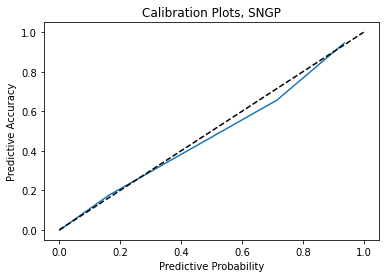

In [26]:
plt.plot(prob_pred, prob_true)

plt.plot([0., 1.], [0., 1.], c='k', linestyle="--")
plt.xlabel('Predictive Probability')
plt.ylabel('Predictive Accuracy')
plt.title('Calibration Plots, SNGP')

plt.show()

## Resources and further reading

* See the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp) for an detailed walkthrough of implementing SNGP from scratch. 
* See [Uncertainty Baselines](https://github.com/google/uncertainty-baselines)  for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (e.g., [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108).
